#**INTERNSHIP CODE**









In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm
from scipy.stats import gamma as gam
import pandas as pd
from scipy.optimize import minimize
from scipy import optimize
from IPython import display
from time import sleep
from scipy import interpolate


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Classic SIR Model

The SIR epidemic model is defined by the system :

\

\begin{equation}
\begin{array}{ll}
\frac{dS}{dt} = - \beta I S \; \; , \; S(0) = S_0 \\
\frac{dI}{dt} = \beta I S - \gamma I \; \, , \; I(0) = I_0 \\
\end{array}
\end{equation}

\

on $T = \{(S,I \; | \; S \geq 0 , \; I \geq 0 , \; I + S \leq 1 \}$

\


The basic reproduction number is the average number of contacts times the average time of the infectious period, so $R_0 = \beta / \gamma$.

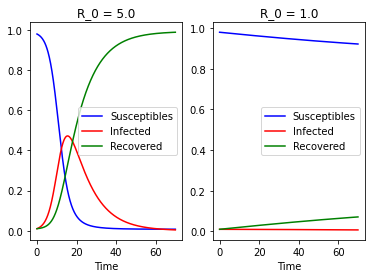

In [3]:
s0 = 0.98
i0 = 0.01
y0 = np.array([s0,i0])
beta = 0.5   #Number of contact per unit of time
gamma = 1/10   #inverse of the mean duration of infectious
t = np.linspace(0,70,1000)

f = lambda y,t : np.array([-beta * y[0]*y[1], beta * y[0]*y[1] - gamma*y[1]])

y = odeint(f,y0,t)

sc,ic = y[:,0],y[:,1]

plt.figure(1)
plt.subplot(121)
plt.plot(t,sc,"blue",label = "Susceptibles")
plt.plot(t,ic,"red",label = "Infected")
plt.plot(t,1-sc-ic,"green",label = "Recovered")
plt.title("R_0 = "+str(beta/gamma))
plt.xlabel("Time")
plt.legend()

beta = 0.1
gamma = 1/10
t = np.linspace(0,70,1000)

f = lambda y,t : np.array([-beta * y[0]*y[1], beta * y[0]*y[1] - gamma*y[1]])

y = odeint(f,y0,t)

s,i = y[:,0],y[:,1]

plt.figure(1)
plt.subplot(122)
plt.plot(t,s,"blue",label = "Susceptibles")
plt.plot(t,i,"red",label = "Infected")
plt.plot(t,1-s-i,"green",label = "Recovered")
plt.title("R_0 = "+str(beta/gamma))
plt.xlabel("Time")
plt.legend()

plt.show()

#Kinetic Model (Social SIR)

Solving of the macroscopic system

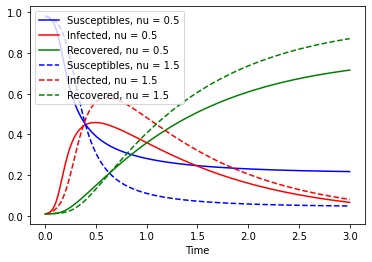

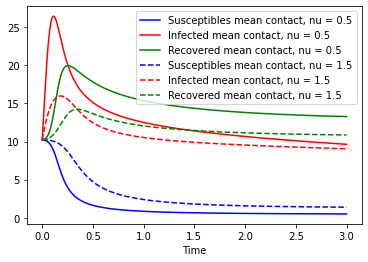

In [4]:
nu = 0.5 # measures the heterogeneity (the heterogeneity increases when nu decreases)
x0 = 10.25
beta = 0.1
gamma = 1
y0 = np.array([0.98,0.01])
c0 = np.array([x0,x0,x0]) # initial mean number of contacts per class
Y0 = np.concatenate((y0,c0))

t = np.linspace(0,3,1000)

f = lambda y,t : np.array([-beta * y[2]*y[3]*y[0]*y[1], beta*y[2]*y[3]*y[0]*y[1] - gamma * y[1], -beta/nu*y[2]**2*y[3]*y[1],beta*y[2]*y[3]*((1+nu)/nu*y[2]-y[3])*y[0],gamma*y[1]/(1-y[0]-y[1])*(y[3]-y[4])])

Y1 = odeint(f,Y0,t)

nu = 1.5

f = lambda y,t : np.array([-beta * y[2]*y[3]*y[0]*y[1], beta*y[2]*y[3]*y[0]*y[1] - gamma * y[1], -beta/nu*y[2]**2*y[3]*y[1],beta*y[2]*y[3]*((1+nu)/nu*y[2]-y[3])*y[0],gamma*y[1]/(1-y[0]-y[1])*(y[3]-y[4])])

Y2 = odeint(f,Y0,t)

s1,i1,xs1,xi1,xr1 = Y1[:,0],Y1[:,1],Y1[:,2],Y1[:,3],Y1[:,4]
s2,i2,xs2,xi2,xr2 = Y2[:,0],Y2[:,1],Y2[:,2],Y2[:,3],Y2[:,4]

plt.figure(2)
plt.plot(t,s1,"blue",label = "Susceptibles, nu = 0.5")
plt.plot(t,i1,"red",label = "Infected, nu = 0.5")
plt.plot(t,1-s1-i1,"green",label = "Recovered, nu = 0.5")
plt.plot(t,s2,"b--",label = "Susceptibles, nu = 1.5")
plt.plot(t,i2,"r--",label = "Infected, nu = 1.5")
plt.plot(t,1-s2-i2,"g--",label = "Recovered, nu = 1.5")
plt.xlabel("Time")
plt.legend()

plt.figure(3)
plt.plot(t,xs1,"blue",label = "Susceptibles mean contact, nu = 0.5")
plt.plot(t,xi1,"red",label = "Infected mean contact, nu = 0.5")
plt.plot(t,xr1,"green",label = "Recovered mean contact, nu = 0.5")
plt.plot(t,xs2,"b--",label = "Susceptibles mean contact, nu = 1.5")
plt.plot(t,xi2,"r--",label = "Infected mean contact, nu = 1.5")
plt.plot(t,xr2,"g--",label = "Recovered mean contact, nu = 1.5")
plt.xlabel("Time")
plt.legend() 

plt.show()


## Solve the kinetic system

First, we test the Monte Carlo method for solving kinetic equation (Nanbu's algorithm).

Here, we do not take into account the kernel $B(x) = 1/x$.

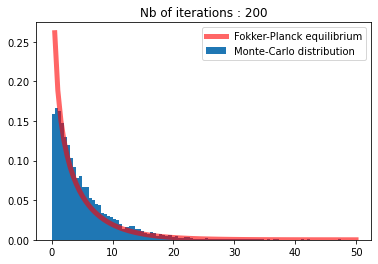

In [5]:
x_M=10.  #mean number of contacts
M = 10**4   #number of particles (population here)
ntot = 201     # steps number
dt = 10**(-1)   #step time
eps = dt        #epsilon
mu = 0.3       #parameter of phi
nu = 1.65          #variance of eta
c = np.sqrt(3*mu/nu*eps)
phi = lambda x : mu * (np.exp(eps * (x/x_M-1))-1)/(np.exp(eps * (x/x_M-1))+1)


def eta(N):
    x = np.random.rand(N)
    return 2*c*x - c

##
def Monte_Carlo_method_animation(ntot,M):
    bins = np.linspace(0,50,100)
    X = 20*np.random.rand(M)
    x_M = 10.
    for n in range(ntot):
        if n//10==n/10:
            plt.figure(1)
            plt.clf()
            plt.hist(X,bins,density = True,label="Monte-Carlo distribution")
            x = np.linspace(0,50,100)
            plt.plot(x, gam.pdf(x, nu-1
            ,scale = x_M/nu),'r-', lw=5, alpha=0.6, label='Fokker-Planck equilibrium')
            plt.legend()
            plt.title("Nb of iterations : "+ str(n))
            display.display(plt.gcf())
            display.clear_output(wait=True)
            sleep(0.5)
        X = X - phi(X)*X + eta(M)*X
    plt.show()

Monte_Carlo_method_animation(ntot,M)

Now, we take into account the kernel $B$.

Some problems because of the divergence in $0$ of $1/x$, so I add a small constant ($0.01$) to the number of contacts of each particle.

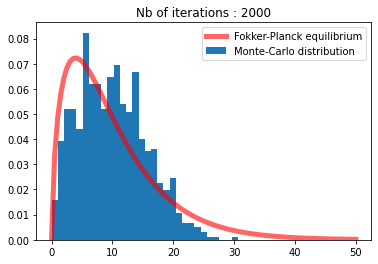

In [6]:
x_M=10.  #mean number of contacts
M = 10**3   #number of particles (population here)
ntot = 2001      # steps number
dt = 10**(-2)   #step time
eps = dt        #epsilon
mu = 0.8      #parameter of phi
nu = 1.65          #variance of eta
c = np.sqrt(3*mu/nu*eps)

def eta():
    x = np.random.rand()
    return 2*c*x - c

def Monte_Carlo_method_kernel_animation(ntot,M):
    X = 1+18*np.random.rand(M)
    x_M = 10.
    bins = np.linspace(0,50,50)
    for n in range(ntot):
        if n//100==n/100:
            plt.figure(1)
            plt.clf()
            plt.hist(X,bins,density = True,label="Monte-Carlo distribution")
            x = np.linspace(0,50,100)
            plt.plot(x, gam.pdf(x, nu, scale = x_M/nu),'r-', lw=5, alpha=0.6, label='Fokker-Planck equilibrium')
            plt.legend()
            plt.title("Nb of iterations : "+ str(n))
            display.display(plt.gcf())
            display.clear_output(wait=True)
            sleep(0.5)
        x_min = np.min(X)
        Xbis=[]
        for i in range(len(X)):
            r = np.random.rand()
            xi = X[i]
            if 1/x_min * r < 1/xi:
                n_xi = xi - phi(xi)*xi +eta()*xi 
                Xbis.append(n_xi)
            else:
                Xbis.append(xi)
        X = np.array(Xbis)
    plt.show()

Monte_Carlo_method_kernel_animation(ntot,M)


Now, we want to solve the following system :
\begin{equation}
\left\{ \begin{array}{ll}
\frac{\partial f_S}{\partial t}(x,t) = -\beta x f_S(x,t)x_I(t)I(t) + \frac{1}{\epsilon} Q_S(f_S)(x,t) \\
\frac{\partial f_I}{\partial t}(x,t) = \beta x f_S(x,t)x_I(t)I(t) - \gamma f_I(x,t) + \frac{1}{\epsilon} Q_I(f_I)(x,t) \\
\frac{\partial f_R}{\partial t}(x,t) = \gamma f_I(x,t) + \frac{1}{\epsilon} Q_R(f_R)(x,t)
\end{array} \right.
\end{equation}

\

We will use a splitting strategy approach and the Monte-Carlo Method.

\

First, we compute the next step $\tilde{f}_S(x,\delta	t)$ of the equation :
\begin{equation*}
\left\{ \begin{array}{ll}
\frac{\partial \tilde{f}_S}{\partial t}(x,t) = \frac{1}{\epsilon}Q_S(\tilde{f}_S)(x,t) \\
\tilde{f}_S(x,0) = f_S(x,0) \end{array} \right.
\end{equation*}

\
 Then, we compute an other step of the following equation taking for initial value $\tilde{f}_S(x, \delta t)$ :
\begin{equation*}
\left\{ \begin{array}{ll}
\frac{\partial f_S}{\partial t}(x,t) = - \beta x f_S(x,t)x_I(t)I(t) \\
f_S(x,0) = \tilde{f}_S(x, \delta t) \end{array} \right.
\end{equation*}


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


<Figure size 432x288 with 0 Axes>

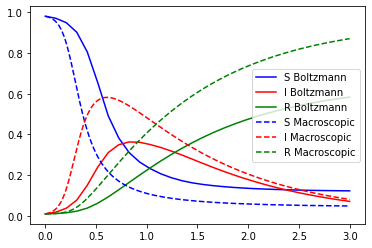

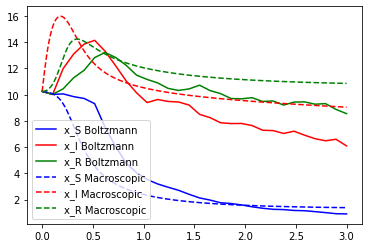

In [7]:
#40 min to execute

n_bins = 200
tmax = 3
bins = np.linspace(0.1,50.1,n_bins)
M = 10**3
dt = 10**(-1)
eps = dt
mu = 0.8
nu = 1.5
c = np.sqrt(3*mu/nu*eps)
phi = lambda x : mu * (np.exp(eps * (x-1))-1)/(np.exp(eps * (x-1))+1)


beta = 0.1
gamma = 1

s0 = 0.98
i0 = 0.01
r0 = 0.01

def sample(f):
    r = np.random.rand()
    i = 0
    s = f[i]
    while i < len(f)-1 and r > s:
        i+=1
        s+=f[i]
    return i

def eta(M):
    x = np.random.rand(M)
    return 2*c*x - c
    
t = np.linspace(0,tmax,int(tmax/dt))

f0 = np.array([int(n_bins/2.5) * [s0/int(n_bins/2.5)] + (n_bins -int(n_bins/2.5))*[0],int(n_bins/2.5) * [i0/int(n_bins/2.5)] + (n_bins -int(n_bins/2.5))*[0],int(n_bins/2.5) * [r0/int(n_bins/2.5)] + (n_bins -int(n_bins/2.5))*[0]])  #initial distributions
average = [10.25,10.25,10.25]   #initial distrib = 1_{[0,20]}

St=[]
It=[]
Rt=[]
xst=[]
xit=[]
xrt=[]


for k in range(int(tmax/dt)):
    print(k)
    xst.append(average[0])
    xit.append(average[1])
    xrt.append(average[2])
    St.append(np.sum(f0[0]))
    It.append(np.sum(f0[1]))
    Rt.append(np.sum(f0[2]))
    plt.figure(1)
    plt.clf()
    for j in range(3):
        X = []
        mass = np.sum(f0[j])
      
        f = f0[j]/mass    #we fix the mass of f equal to 1
        for i in range(M):
            X.append(bins[sample(f)])  #we sample particles for each class 
        x_min = np.min(X)
        mean = 0
        X = np.array(X)
        for l in range(len(f0[j])):
            mean += bins[l]*f[l]
        average[j]=mean
        for iter in range(200):
          r = np.random.rand(M)
          alea = eta(M)
          indic = (1+np.sign(1/X - r*1/x_min))/2
          X = X - indic*(phi(X/mean)*X + alea*X)
        f0[j],x_hist = np.histogram(X,n_bins,(0.1,50.1),density = True) #update of density
        f0[j] = f0[j]/np.sum(f0[j])*mass
    I = np.sum(f0[1])
    for i in range(len(f0[0])):  #transport equation solve
        x = bins[i]
        f0[0][i] = f0[0][i] - dt * beta * x * f0[0][i] * average[1] * I
        f0[1][i] = f0[1][i] + dt * (beta * x * f0[0][i] * average[1] * I - gamma*f0[1][i])
        f0[2][i] = f0[2][i] + dt * gamma * f0[1][i]

t_comp = np.linspace(0,3,1000)

plt.figure(3)
plt.plot(t,St,"b",label = 'S Boltzmann')
plt.plot(t,It,"r",label = 'I Boltzmann')
plt.plot(t,Rt,"g",label = 'R Boltzmann')
plt.plot(t_comp,s2,"b--",label = 'S Macroscopic')
plt.plot(t_comp,i2,"r--",label = 'I Macroscopic')
plt.plot(t_comp,1-s2-i2,"g--",label = 'R Macroscopic')
plt.legend()
plt.show()
    
plt.figure(2)
plt.plot(t,xst,"b",label = 'x_S Boltzmann')
plt.plot(t,xit,"r",label = 'x_I Boltzmann')
plt.plot(t,xrt,"g",label = 'x_R Boltzmann')
plt.plot(t_comp,xs2,"b--",label = 'x_S Macroscopic')
plt.plot(t_comp,xi2,"r--",label = 'x_I Macroscopic')
plt.plot(t_comp,xr2,"g--",label = 'x_R Macroscopic')
plt.legend()
plt.show()
        

#Model Fitting from data

First we will find the parameters $\beta$ and $\gamma$ for the classic SIR model using data from France.

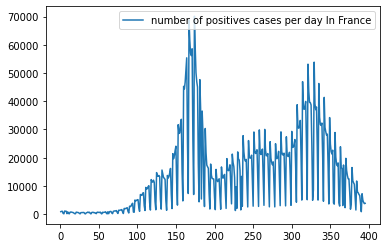

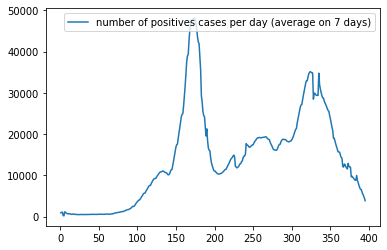

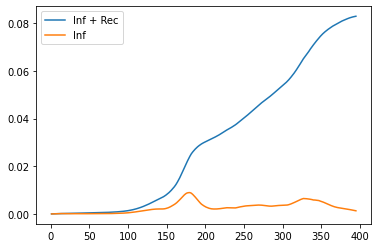

In [8]:
data = pd.read_csv ('FR_data.csv', delimiter=";")

pos_data =[]

i=0
while i < len(data):
    p=data.loc[i+10,"P"]
    pos_data.append(p)
    i+=11

pos_data = np.array(pos_data)  #original data (number of positive cases per day)
n = len(pos_data)

pos_data_moyenne = np.copy(pos_data)

for i in range(7,n-1):
    pos_data_moyenne[i] = np.average(pos_data[i-6:i+1])  #average on 7 days


plt.figure(1)
plt.plot(np.linspace(1,n,n), pos_data, label = "number of positives cases per day In France")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(np.linspace(1,n,n), pos_data_moyenne, label = "number of positives cases per day (average on 7 days)")
plt.legend()
plt.show()

pos_data_moyenne = pos_data_moyenne/67000000   #fraction of positive cases

Inf_Rec = np.copy(pos_data_moyenne)
for k in range(1,n):
    Inf_Rec[k] +=Inf_Rec[k-1]     # I + R data

Inf = np.copy(pos_data_moyenne)
for k in range(13):
  Inf[k]=np.sum(pos_data_moyenne[0:k])
for k in range(13,n):
  Inf[k]=np.sum(pos_data_moyenne[k-12:k+1])

plt.figure(3)
plt.plot(np.linspace(1,n,n),Inf_Rec,label = "Inf + Rec")
plt.plot(np.linspace(1,n,n),Inf,label = "Inf")
plt.legend()
plt.show()

N = 67000000




Data are taken from march 2020 to april 2021. In order to fit the SIR model we will use data from june to october, corresponding to a period without lockdown. We do not use data before the first lockdown because a few test were realised.

\

We solve the following optimisation problem : setting $\hat{I},\hat{R}$ the number of infected and recovered people from data, and $I, R$ infected and recovered people from SIR model we solve :

\begin{equation}
\min\limits_{\beta , \gamma} \; \; p\frac{||\hat{I} - I ||_2}{||\hat{I} ||_2} +(1-p)\frac{||\hat{I} + \hat{R} - I - R ||_2}{||\hat{I} + \hat{R}||_2}.
\end{equation}
with $p = 0.1$.

# SECOND WAVE


In [9]:
t0 = 155 #begin of october
tf = 170  #end of october

def solve(x):
    beta = x[0]
    gamma = x[1]
    y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
    t = np.linspace(0,tf-t0,tf-t0+1)
    f = lambda y,t : np.array([-beta * y[0]*y[1], beta * y[0]*y[1] - gamma*y[1]])
    y = odeint(f,y0,t)
    s1,i1 = y[:,0],y[:,1]
    n1=0
    n2=0
    v1=0
    v2=0
    for i in range(tf-t0):
        n1+=(Inf_Rec[t0 +i]-(1-s1[i]))**2
        v1+=Inf_Rec[t0 +i]**2
        n2+=(Inf[t0+i]-i1[i])**2
        v2+=Inf[t0+i]**2
    return 1000*(0.9*np.sqrt(n2/v2) + 0.1*np.sqrt(n1/v1))

res = minimize(solve,[1,1],method = 'trust-constr',bounds = [(0.01,None),(1/14,1/7)])

print(res)

x_fit = res.x

print(" \n \n We find R_0 = " + str(x_fit[0]/x_fit[1]))

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 204
      cg_stop_cond: 4
            constr: [array([0.12923365, 0.07143222])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.6509931087493896
               fun: 10.327380444356919
              grad: array([2.15201020e-01, 2.82728365e+02])
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([3.01655509e-03, 3.76013531e-09])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 408
              nhev: 0
               nit: 174
             niter: 174
              njev: 0
        optimality: 0.0030165550912052974
            status: 2
           success: True
         tr_radius: 1.0000000000000005e-09
             

We can now plot the number of cases per day from data and SIR to compare. 

\

Then, we can try to make prediction about the future = look at what it would happened if we did not impose a lockdown.

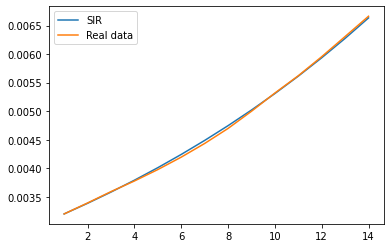

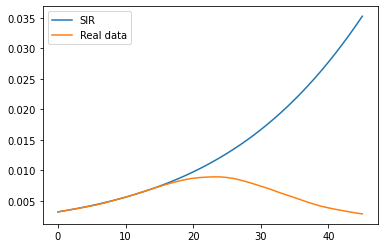

In [10]:
tf2 = 200  #November

beta = x_fit[0]
gamma = x_fit[1]
y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
t = np.linspace(0,tf2-t0,tf2-t0+1)
f = lambda y,t : np.array([-beta * y[0]*y[1], beta * y[0]*y[1] - gamma*y[1]])
y = odeint(f,y0,t)
s1,i1 = y[:,0],y[:,1]

day_cases = i1[1::]-i1[0:-1:]+(1-s1[1::]-i1[1::])-(1-s1[0:-1:]-i1[0:-1:])
plt.figure(1)
plt.plot(t[1:tf-t0:],i1[:tf-t0-1],label = "SIR")
plt.plot(t[1:tf-t0:],Inf[t0:tf-1],label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i1,label = "SIR")
plt.plot(t,Inf[t0:tf2+1:],label="Real data")
plt.legend()
plt.show()


In [11]:
x_H = np.array([])

t0 = 150
tf = 195
db = 1
da = 2

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  beta = x_fit[0]
  gamma = x_fit[1]
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[1]*H[0],beta*y[0]*y[1]*H[0] - gamma * y[1]])
      y0 = np.array([1-Inf_Rec[d-db],Inf[d-db]])
      y = np.zeros((2,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,i1 = y[0,:],y[1,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,1)]))
  x_H =np.concatenate((x_H,res.x))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]


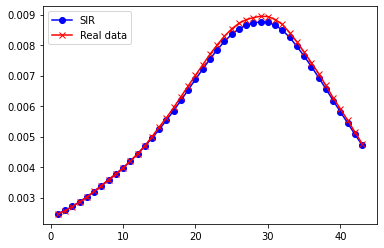

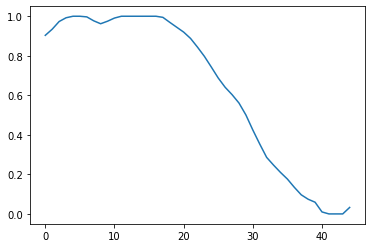

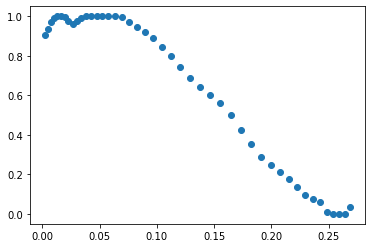

In [12]:
H = x_H

t = np.linspace(0,tf-t0,tf-t0+1)
print(t)

f = lambda y , t : np.array([-beta*y[0]*y[1]*H[int(t)],beta*y[0]*y[1]*H[int(t)] - gamma * y[1]])
y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
y = np.zeros((2,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]
day_cases = i1[1::]-i1[0:-1:]+(1-s1[1::]-i1[1::])-(1-s1[0:-1:]-i1[0:-1:])
plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1[:tf-t0-2],"b-o",label = "SIR")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:-1],H)
plt.show()

Inf_cum = [Inf[t0]]

for k in range(t0,tf):
  Inf_cum.append(Inf_cum[-1]+Inf[k])

plt.figure(3)
plt.plot(Inf_cum[:-1],H,"o")
plt.show()

# THIRD WAVE

In [13]:
x_H = np.array([])

t0 = 310
tf = 383
db = 1
da = 2

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  beta = x_fit[0]
  gamma = x_fit[1]
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[1]*H[0],beta*y[0]*y[1]*H[0] - gamma * y[1]])
      y0 = np.array([1-Inf_Rec[d-db],Inf[d-db]])
      y = np.zeros((2,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,i1 = y[0,:],y[1,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,1)]))
  x_H =np.concatenate((x_H,res.x))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

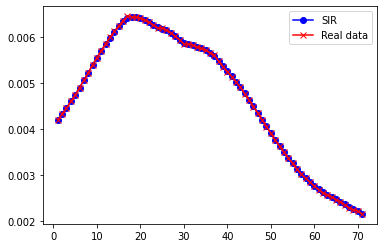

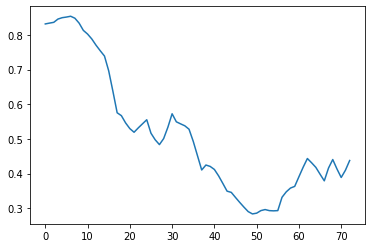

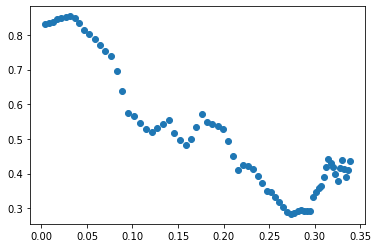

In [14]:
H_3 = x_H

t = np.linspace(0,tf-t0,tf-t0+1)

f = lambda y , t : np.array([-beta*y[0]*y[1]*H_3[int(t)],beta*y[0]*y[1]*H_3[int(t)] - gamma * y[1]])
y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
y = np.zeros((2,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]
day_cases = i1[1::]-i1[0:-1:]+(1-s1[1::]-i1[1::])-(1-s1[0:-1:]-i1[0:-1:])
plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1[:tf-t0-2],"b-o",label = "SIR")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:-1],H_3)
plt.show()

Inf_cum = [Inf[t0]]

for k in range(t0,tf):
  Inf_cum.append(Inf_cum[-1]+Inf[k])

plt.figure(3)
plt.plot(Inf_cum[:-1],H_3,"o")
plt.show()

---
## Endemic model with vaccination

The endemic kinetic model follows combining the epidemic process with the contact dynamics. This gives the system :
\begin{equation}
\left\{ \begin{array}{ll}
\frac{\partial f_S}{\partial t}(x,t) = -K(f_S,f_I)(x,t) + \zeta_i f_{R_i}(x,t)+ \zeta_v f_{R_v}(x,t) - V f_S(x,t) + \frac{1}{\tau} Q_S(f_S)(x,t) \\
\frac{\partial f_E}{\partial t}(x,t) = K(f_S,f_I)(x,t) - \epsilon f_E(x,t) + \frac{1}{\tau} Q_E(f_E)(x,t) \\
\frac{\partial f_I}{\partial t}(x,t) =  \epsilon f_E(x,t) - \gamma f_I(x,t) + \frac{1}{\tau} Q_I(f_I)(x,t) \\
\frac{\partial f_{R_i}}{\partial t}(x,t) = \gamma f_I(x,t) - \zeta_i f_{R_i}(x,t) + \frac{1}{\tau} Q_{R_i}(f_{R_i})(x,t) \\
\frac{\partial f_{R_v}}{\partial t}(x,t) = V f_S(x,t) - \zeta_v f_{R_v}(x,t) + \frac{1}{\tau} Q_{R_v}(f_{R_v})(x,t)
\end{array} \right.
\end{equation}
\
where $K(f_S,f_I)(x,t) = \beta x f_S(x,t)x_I(t)I(t)$, $\beta$ is the infection rate, $1/\zeta_i$ (resp $1/\zeta_v$) the mean time of infectious immunity (resp vaccine immunity), $1/\epsilon$ the latent period, $1/\gamma$ the mean duration of infection and $V$ the vaccination rate.

If we assume that all parameters are known except $V$, we can find a condition on $V$ to reach the disease-free equilibrium :
\begin{equation}
V \geq \frac{\beta \zeta_v x_0^2}{2 \gamma} \left[ \left( \frac{\nu +1}{\nu} - \frac{2 \gamma}{\beta x_0^2} \right) + \sqrt{\left(\frac{2 \gamma}{\beta x_0^2} - \frac{\nu + 1}{\nu} \right)^2 - \frac{4 \gamma}{\beta x_0^2} \left( \frac{\gamma}{\beta x_0^2} - \frac{\nu + 1}{\nu} \right)} \right]
\end{equation}



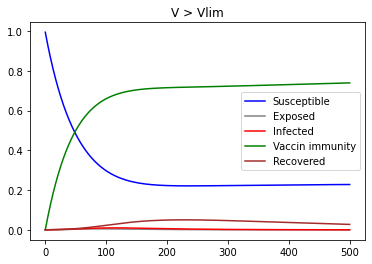

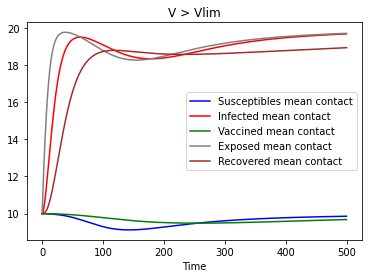

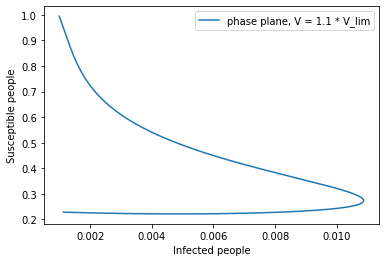

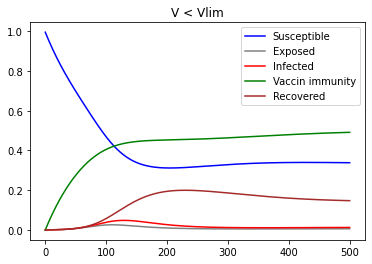

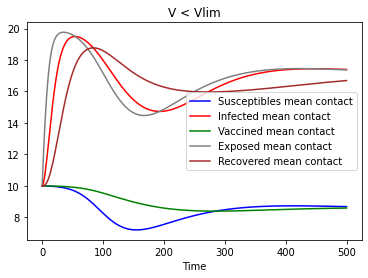

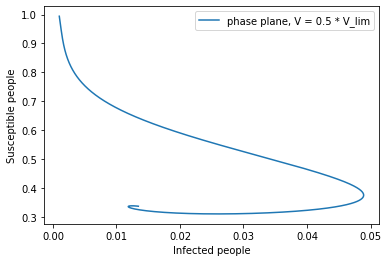

In [15]:
x0 = 10
beta = 0.1/x0**2
gamma = 0.05
eps = 2*gamma
zeta_i = gamma/10
zeta_v = gamma/10

nu = 1
s0 = 0.994
i0 = 0.001
e0 = 0.001
ri0 = 0.001
rv0 = 0.001

Vlim = beta*zeta_v**2*x0**2/(2*gamma*zeta_v)*(((nu+1)/nu - 2*gamma/(beta*x0**2)) + np.sqrt((2*gamma/(beta*x0**2)-(nu+1)/nu)**2-4*gamma/(beta*x0**2)*(gamma/(beta*x0**2)-(nu+1/nu))))

V = Vlim*1.1

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,500,20000)

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])



Y = odeint(f,CI,t)

s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]

plt.figure()
plt.plot(t,s,color = 'blue',label = "Susceptible")
plt.plot(t,e,color = "grey",label = "Exposed")
plt.plot(t,i,color = "red",label = "Infected")
plt.plot(t,rv, color = "green",label = "Vaccin immunity")
plt.plot(t,ri,color = "brown",label = "Recovered")
plt.title("V > Vlim")
plt.legend()
plt.show()

plt.figure()
plt.plot(t,xs,"blue",label = "Susceptibles mean contact")
plt.plot(t,xi,"red",label = "Infected mean contact")
plt.plot(t,xrv,"green",label = "Vaccined mean contact")
plt.plot(t,xe,"grey",label = "Exposed mean contact")
plt.plot(t,xri,"brown",label = "Recovered mean contact")
plt.xlabel("Time")
plt.title("V > Vlim")
plt.legend() 
plt.show()

plt.figure()
plt.plot(i,s,label="phase plane, V = 1.1 * V_lim")
plt.xlabel('Infected people')
plt.ylabel('Susceptible people')
plt.legend()
plt.show()

V = Vlim*0.5

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,500,20000)

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])



Y = odeint(f,CI,t)

s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]

plt.figure()
plt.plot(t,s,color = 'blue',label = "Susceptible")
plt.plot(t,e,color = "grey",label = "Exposed")
plt.plot(t,i,color = "red",label = "Infected")
plt.plot(t,rv, color = "green",label = "Vaccin immunity")
plt.plot(t,ri,color = "brown",label = "Recovered")
plt.title("V < Vlim")
plt.legend()
plt.show()

plt.figure()
plt.plot(t,xs,"blue",label = "Susceptibles mean contact")
plt.plot(t,xi,"red",label = "Infected mean contact")
plt.plot(t,xrv,"green",label = "Vaccined mean contact")
plt.plot(t,xe,"grey",label = "Exposed mean contact")
plt.plot(t,xri,"brown",label = "Recovered mean contact")
plt.xlabel("Time")
plt.title("V < Vlim")
plt.legend() 
plt.show()

plt.figure()
plt.plot(i,s,label="phase plane, V = 0.5 * V_lim")
plt.xlabel('Infected people')
plt.ylabel('Susceptible people')
plt.legend()
plt.show()

##SEIR Model fitting

We use SEIR model to get values of $\beta$, $\gamma$, and $\epsilon$.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


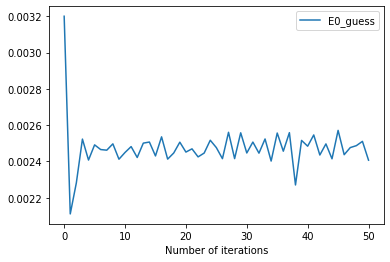

 
 
 We find R_0 = 2.952531548074643
 beta = 0.15414999224892567
 epsilon = 0.14287491294444662
 gamma = 0.05220943103874621


In [16]:
t0 = 155 #begin of october
tf = 170  #end of october

N = 67000000

E0_guess = Inf[t0]
E0_list = [E0_guess]

for k in range(50):
  print(k)
  def solve(x):
      beta = x[0]
      epsilon = x[1]
      gamma = x[2]
      y0 = np.array([1-Inf_Rec[t0]-E0_guess,E0_guess,Inf[t0]])
      t = np.linspace(0,tf-t0,tf-t0+1)
      f = lambda y,t : np.array([-beta * y[0]*y[2], beta * y[0]*y[2] - epsilon*y[1],epsilon*y[1]-gamma*y[2]])
      y = odeint(f,y0,t)
      s1,e1,i1 = y[:,0],y[:,1],y[:,2]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(tf-t0):
          n1+=(Inf_Rec[t0 +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[t0 +i]**2
          n2+=(Inf[t0+i]-i1[i])**2
          v2+=Inf[t0+i]**2
      return 1000*(0.1*np.sqrt(n2/v2) + 0.9*np.sqrt(n1/v1))
  res = minimize(solve,[0.1,0.2,1],method = 'trust-constr',bounds = [(0.,1),(1/7,1/3),(1/20,1/5)])
  x_fitE = res.x
  [beta,epsilon,gamma] = x_fitE
  f = lambda y,t : np.array([-beta * y[0]*y[2], beta * y[0]*y[2] - epsilon*y[1],epsilon*y[1]-gamma*y[2]])
  y0 = np.array([(N-1)/N,1/N,0])
  It = 0
  y = [y0]
  t = np.linspace(0,tf-t0,tf-t0+1)
  while It < Inf[t0]:
    k1 = f(y[-1][:],t[0])
    k2 = f(y[-1][:]+k1/2,t[0]+1/2)
    k3 = f(y[-1][:]+k2/2,t[0]+1/2)
    k4 = f(y[-1][:]+k3,t[0]+1)
    y.append( y[-1][:] +1/6*(k1+2*k2+2*k3+k4))
    It = y[-1][2]
  E0_guess = y[-1][1]
  E0_list.append(E0_guess)

plt.figure()
plt.plot([k for k in range(len(E0_list))],E0_list,label = "E0_guess")
plt.xlabel("Number of iterations")
plt.legend()
plt.show()

def solve(x):
      beta = x[0]
      epsilon = x[1]
      gamma = x[2]
      y0 = np.array([1-Inf_Rec[t0]-E0_guess,E0_guess,Inf[t0]])
      t = np.linspace(0,tf-t0,tf-t0+1)
      f = lambda y,t : np.array([-beta * y[0]*y[2], beta * y[0]*y[2] - epsilon*y[1],epsilon*y[1]-gamma*y[2]])
      y = odeint(f,y0,t)
      s1,e1,i1 = y[:,0],y[:,1],y[:,2]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(tf-t0):
          n1+=(Inf_Rec[t0 +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[t0 +i]**2
          n2+=(Inf[t0+i]-i1[i])**2
          v2+=Inf[t0+i]**2
      return 1000*(0.1*np.sqrt(n2/v2) + 0.9*np.sqrt(n1/v1))
res = minimize(solve,[0.1,0.2,1],method = 'trust-constr',bounds = [(0.,1),(1/7,1/3),(1/20,1/5)])
x_fit_E = res.x

E0_guess_2 = E0_guess

print(" \n \n We find R_0 = " + str(x_fit_E[0]/x_fit_E[2])+"\n beta = "+str(x_fit_E[0])+"\n epsilon = "+str(x_fit_E[1])+"\n gamma = "+str(x_fit_E[2]))

In [17]:
t0 = 310
tf = 315

beta = x_fit_E[0]
epsilon = x_fit_E[1]
gamma = x_fit_E[2]
def solve(x):
      e0 = x[0]
      y0 = np.array([1-Inf_Rec[t0]-e0,e0,Inf[t0]])
      t = np.linspace(0,tf-t0,tf-t0+1)
      f = lambda y,t : np.array([-beta * y[0]*y[2], beta * y[0]*y[2] - epsilon*y[1],epsilon*y[1]-gamma*y[2]])
      y = odeint(f,y0,t)
      s1,e1,i1 = y[:,0],y[:,1],y[:,2]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(tf-t0):
          n1+=(Inf_Rec[t0 +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[t0 +i]**2
          n2+=(Inf[t0+i]-i1[i])**2
          v2+=Inf[t0+i]**2
      return 1000*(0.1*np.sqrt(n2/v2) + 0.9*np.sqrt(n1/v1))
res = minimize(solve,[0.1],method = 'Nelder-Mead')
E0_guess = res.x[0]
print(E0_guess)

0.0021826171875001903


In [18]:
x_H = np.array([])

t0 = 310
tf = 383
db = 1
da = 5

beta = x_fit_E[0]
epsilon = x_fit_E[1]
gamma = x_fit_E[2]
e0 = E0_guess

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[2]*H[0],beta*y[0]*y[2]*H[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2]])
      y0 = np.array([1-Inf_Rec[d-db]-e0,e0,Inf[d-db]])
      y = np.zeros((3,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,e1,i1 = y[0,:],y[1,:],y[2,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,1)]))
  x_H =np.concatenate((x_H,res.x))
  f = lambda y , t : np.array([-beta*y[0]*y[2]*res.x[0],beta*y[0]*y[2]*res.x[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2]])
  y0 = np.array([1-Inf_Rec[d-db]-e0,e0,Inf[d-db]])
  y = np.zeros((3,db+da+1))
  y[:,0] = y0
  for k in range(1,db+da+1):
    k1 = f(y[:,k-1],t[k-1])
    k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
    k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
    k4 = f(y[:,k-1]+k3,t[k-1]+1)
    y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
  s1,e1,i1 = y[0,:],y[1,:],y[2,:]
  e0 = e1[1]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

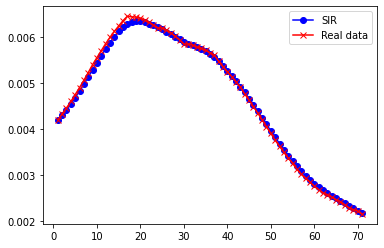

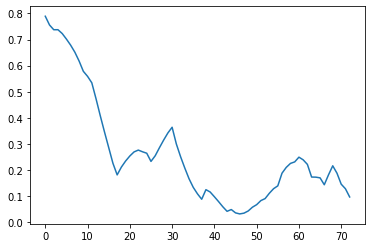

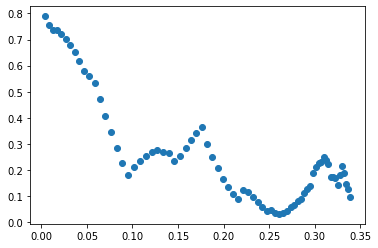

In [19]:
H_E = x_H

t = np.linspace(0,tf-t0,tf-t0+1)

f = lambda y , t : np.array([-beta*y[0]*y[2]*H_E[int(t)],beta*y[0]*y[2]*H_E[int(t)] - epsilon * y[1],epsilon*y[1]-gamma*y[2]])
y0 = np.array([1-Inf_Rec[t0]-E0_guess,E0_guess,Inf[t0]])
y = np.zeros((3,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,e1,i1 = y[0,:],y[1,:],y[2,:]
plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1[:tf-t0-2],"b-o",label = "SIR")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:-1],H_E)
plt.show()

Inf_cum = [Inf[t0]]

for k in range(t0,tf):
  Inf_cum.append(Inf_cum[-1]+Inf[k])

plt.figure(3)
plt.plot(Inf_cum[:-1],H_E,"o")
plt.show()

#Importation of vaccination data

845
 final_simplex: (array([[0.00253906],
       [0.00258789]]), array([0.00146208, 0.00149793]))
           fun: 0.0014620791924420263
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([0.00253906])
 final_simplex: (array([[0.00610352],
       [0.00605469]]), array([0.01494513, 0.01495163]))
           fun: 0.014945125034424087
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([0.00610352])


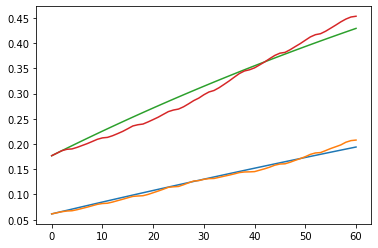

In [20]:
data = pd.read_csv ('FR_vaccin.csv', delimiter=";")

data_vaccine = data

print(len(data.values))

#We use the number of vaccination during last 60 days

n_days = 60
s_0 = 1 - data.loc[844-n_days,"n_cum_dose2"]/67000000
v_0 = data.loc[844-n_days,"n_cum_dose2"]/67000000
y_0 = [s_0,v_0]
t = np.linspace(0,n_days,n_days+1)

def solve_vaccin(x):
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(n_days + 1):
    norm += (v[k] - data.loc[844-n_days+k,"n_cum_dose2"]/67000000)**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')

print(res)

V_estimation2 = res.x[0]

f_v = lambda y, t : np.array([-V_estimation2*y[0],V_estimation2*y[0]])
Y = odeint(f_v,y_0,t)
s_v, v = Y[:,0], Y[:,1]

plt.plot(t,v)
plt.plot(t,data.loc[844-n_days::,"n_cum_dose2"]/67000000)



s_0 = 1 - data.loc[844-n_days,"n_cum_dose1"]/67000000
v_0 = data.loc[844-n_days,"n_cum_dose1"]/67000000
y_0 = [s_0,v_0]
t = np.linspace(0,n_days,n_days+1)

def solve_vaccin(x):
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(n_days + 1):
    norm += (v[k] - data.loc[844-n_days+k,"n_cum_dose1"]/67000000)**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')

print(res)

V_estimation1 = res.x[0]

f_v = lambda y, t : np.array([-V_estimation1*y[0],V_estimation1*y[0]])
Y = odeint(f_v,y_0,t)
s_v, v = Y[:,0], Y[:,1]

plt.plot(t,v)
plt.plot(t,data.loc[844-n_days::,"n_cum_dose1"]/67000000)




Here, we will assume that vaccines give immunity during 6 months, and same for immunity given by an infection. Then, we assume that the mean number of contacts is 10, we can modify this parameter to simulate external measures.

According to data given by Sante Publique France, the number of susceptibles is 60 000 000 (higher than the reality), the current number of people vaccinated is 8 000 000.

We will simulate assuming that we stop all measures now.


In [21]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180
V = 0.01

nu = 1 
i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = i0
s0=1-i0-e0-ri0-rv0

Vlim = beta*zeta_v**2*x0**2/(2*gamma*zeta_v)*(((nu+1)/nu - 2*gamma/(beta*x0**2)) + np.sqrt((2*gamma/(beta*x0**2)-(nu+1)/nu)**2-4*gamma/(beta*x0**2)*(gamma/(beta*x0**2)-(nu+1/nu))))

print("To eradicate COVID-19, V should be greater than +"+str(Vlim)+"\n Today, V = "+str(V_estimation2))

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,700,20000)

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])

Y = odeint(f,CI,t)

s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]




To eradicate COVID-19, V should be greater than +0.027250350534162703
 Today, V = 0.002539062499999114


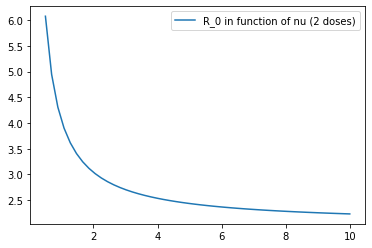

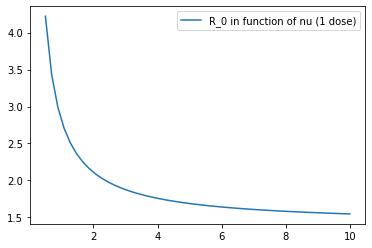

In [22]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180
V = V_estimation2
Nu = np.linspace(0.5,10,50)

R0 = beta*(Nu+1)*x0**2*zeta_v/(gamma*Nu*(zeta_v+V))

plt.plot(Nu,R0,label='R_0 in function of nu (2 doses)')
plt.legend()
plt.show()


x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180
V = V_estimation1
Nu = np.linspace(0.5,10,50)

R0 = beta*(Nu+1)*x0**2*zeta_v/(gamma*Nu*(zeta_v+V))

plt.plot(Nu,R0,label='R_0 in function of nu (1 dose)')
plt.legend()
plt.show()

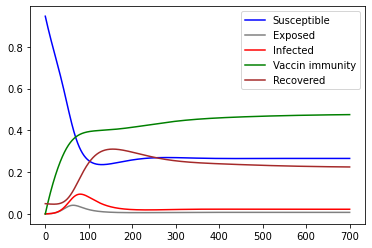

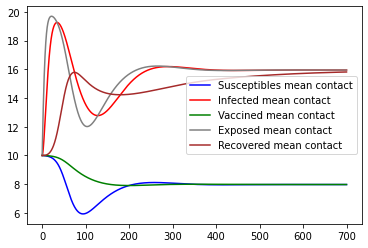

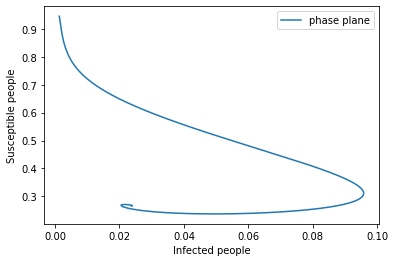

In [23]:
plt.figure()
plt.plot(t,s,color = 'blue',label = "Susceptible")
plt.plot(t,e,color = "grey",label = "Exposed")
plt.plot(t,i,color = "red",label = "Infected")
plt.plot(t,rv, color = "green",label = "Vaccin immunity")
plt.plot(t,ri,color = "brown",label = "Recovered")
plt.legend()
plt.show()

plt.figure()
plt.plot(t,xs,"blue",label = "Susceptibles mean contact")
plt.plot(t,xi,"red",label = "Infected mean contact")
plt.plot(t,xrv,"green",label = "Vaccined mean contact")
plt.plot(t,xe,"grey",label = "Exposed mean contact")
plt.plot(t,xri,"brown",label = "Recovered mean contact")
plt.legend() 
plt.show()

plt.figure()
plt.plot(i,s,label="phase plane")
plt.xlabel('Infected people')
plt.ylabel('Susceptible people')
plt.legend()
plt.show()

We can simulate a stop in the vaccination dynamic (production issue for example) to understand the consequences this kind of problem, and to make forecasts.

In [24]:
f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])

V=0.01

def g(y,t):
  if t < 50:
    return f(y,t)
  else:
    return np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3],  - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),0])

t = np.linspace(0,700,20000)

Y = odeint(g,CI,t)

ss,es,i_s,ris,rvs,xss,xes,xis,xris,xrvs = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]


In [25]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180
V = 0

nu = 1 
i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = i0
s0=1-i0-e0-ri0-rv0


Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,700,20000)

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])

Y = odeint(f,CI,t)

s_nv,e_nv,i_nv,ri_nv,rv_nv,xs_nv,xe_nv,xi_nv,xri_nv,xrv_nv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]

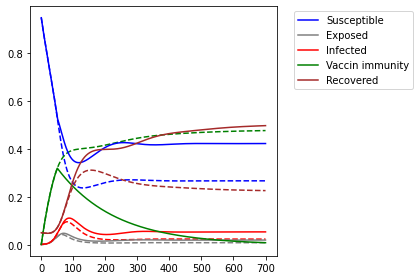

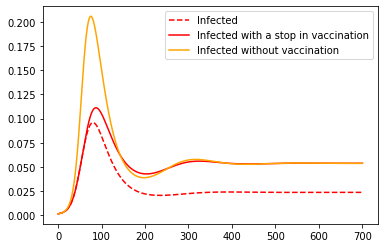

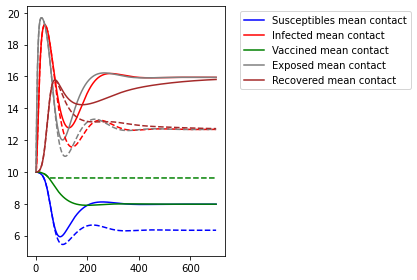

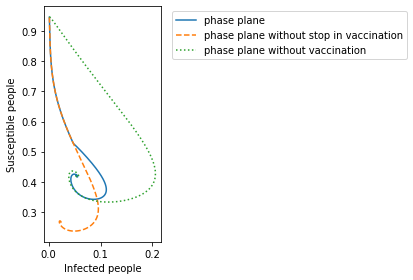

In [26]:
plt.figure()
plt.plot(t,s,color = 'blue',linestyle = '--')
plt.plot(t,e,color = "grey",linestyle = '--')
plt.plot(t,i,color = "red",linestyle = '--')
plt.plot(t,rv, color = "green",linestyle = '--')
plt.plot(t,ri,color = "brown",linestyle = '--')
plt.plot(t,ss,color = 'blue',label = "Susceptible")
plt.plot(t,es,color = "grey",label = "Exposed")
plt.plot(t,i_s,color = "red",label = "Infected")
plt.plot(t,rvs, color = "green",label = "Vaccin immunity")
plt.plot(t,ris,color = "brown",label = "Recovered")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t,i,color = "red",linestyle = '--',label = 'Infected')
plt.plot(t,i_s,color = "red",label = "Infected with a stop in vaccination")
plt.plot(t,i_nv,color = "orange",label = "Infected without vaccination")
plt.legend()
plt.show()

plt.figure()
plt.plot(t,xs,"blue",label = "Susceptibles mean contact")
plt.plot(t,xi,"red",label = "Infected mean contact")
plt.plot(t,xrv,"green",label = "Vaccined mean contact")
plt.plot(t,xe,"grey",label = "Exposed mean contact")
plt.plot(t,xri,"brown",label = "Recovered mean contact")
plt.plot(t,xss,color = 'blue',linestyle = '--')
plt.plot(t,xis,color = "red",linestyle = '--')
plt.plot(t,xrvs,color = "green",linestyle = '--')
plt.plot(t,xes, color = "grey",linestyle = '--')
plt.plot(t,xris,color = "brown",linestyle = '--')
plt.legend() 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(i_s,ss,label="phase plane")
plt.plot(i,s,linestyle='--',label="phase plane without stop in vaccination")
plt.plot(i_nv,s_nv,linestyle=':',label="phase plane without vaccination")
plt.xlabel('Infected people')
plt.ylabel('Susceptible people')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

Stopping vaccination drive to the same endemic equilibrium than without vaccination. However, the peak of infected people is less than the case without vaccination, so vaccinatino can be a good tool to flat the peak.

## Strategy of vaccination

Is it better to vaccinate a lot in a few time to flatten the peak than to vaccinate less but during a longer period ?

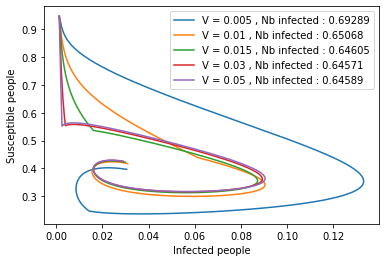

In [27]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/360
zeta_v = 1/360
V = 0.02


nu = 1 
i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = i0
s0=1-i0-e0-ri0-rv0


Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
tmax = 360
t = np.linspace(0,tmax,20000)

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])


g = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3],  - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),0])

n = len(t)

plt.figure()
V_list = [0.005,0.01,0.015,0.03,0.05]
for k in range(len(V_list)):
  V = V_list[k]
  Y = np.zeros((n,10))
  Y[0] = CI
  n_Rv = 0
  iter = 1
  n_I = 0
  while iter < n and n_Rv+ Y[iter-1,4] < 0.4:
    Y[iter] = Y[iter - 1] + tmax/n* f(Y[iter - 1],t[iter])
    n_Rv += tmax/n*zeta_v*Y[iter,4]
    n_I += tmax/n*eps*Y[iter,1]
    iter += 1
  while iter < n:
    Y[iter] = Y[iter - 1] + tmax/n*g(Y[iter - 1],t[iter])
    n_I += tmax/n*eps*Y[iter,1]
    iter += 1
  s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]
  plt.plot(i,s,label="V = "+str(V)+" , Nb infected : "+str(int(100000*n_I)/100000))

plt.xlabel('Infected people')
plt.ylabel('Susceptible people')
plt.legend()
plt.show()




# Study of the stability of equilibriums

Depending on the values of parameters, the solution of the system of ODEs can reach a disease-free equilibrium or an endemic equilibrium. The study of the stability of these equilibriums is necessary to understand an endemic phenomenon.

\

We will study both disease-free equilibrium and endemic equilibrium.

## Disease-free equilibrium 

To study this equilibrium, we will first assume that the limits of the mean of the social contacts number is fixed, so we can not change these values. Indeed, without this assumption, there is a problem in the linearisation because the system is not defined in $I = 0$ because there is no sense to consider the mean of an empty population.

The disease-free equilibrium is defined by :
\begin{equation}
\left\{ \begin{array}{ll}
S^{\infty} = \frac{\zeta_v}{V + \zeta_v} \\
E^{\infty} = 0 \\
I^{\infty} = 0 \\
R_i^{\infty} = 0 \\
R_v^{\infty} = \frac{V}{V + \zeta_v} \\
x_S^{\infty} = x_{R_v}^{\infty} = x_0 \\
x_E^{\infty} = x_I^{\infty} = x_{R_i}^{\infty} = \frac{\nu + 1}{\nu}x_0
\end{array} \right.
\end{equation}

Using the following macroscopic equation and considering that $x_I$ and $x_S$ are fixed to $x_I^{\infty}$ and $x_S^{\infty}$, we study the disease-free equilibrium by linearization.

\

\begin{equation} 
\left\{ \begin{array}{ll}
\frac{\partial S}{\partial t} = -\beta x_S(t)x_I(t)I(t)S(t) + \zeta_i R_i(t) + \zeta_v R_v(t) - VS(t) \\
\frac{\partial E}{\partial t} = \beta x_S(t)x_I(t)I(t)S(t) - \epsilon E(t)  \\
\frac{\partial I}{\partial t} = \epsilon E(t) - \gamma I(t) \\
\frac{\partial R_i}{\partial t} = \gamma I(t) - \zeta_i R_i(t) \\
\frac{\partial R_v}{\partial t} = V S(t) - \zeta_v R_v(t)
\end{array} \right.
\end{equation}

\

We obtain that $0$ is an eigen value of the linear system, so we can not conclude on the stability of the disease-free equilibrium. However, we find that there is a eigen value with a positive real part if and only if $\frac{\beta (\nu + 1) x_0^2 \zeta_v}{\gamma \nu(\zeta_v + V)} > 1$. As the threshold $R_0$ separate the case stable and the case unstable in the classic SIR model, we can fix :
\begin{equation}
R_0 = \frac{\beta (\nu+1) x_0^2 \zeta_v}{\gamma \nu (\zeta_v + V)}
\end{equation}
and if $R_0 > 1$, the disease-free equilibrium is unstable.

\

We will study later the stability when $R_0 \leq 1$ using Lyapunov functions.

\

Remark : The general expression for $R_0$ is :

\begin{equation}
R_0 = \frac{\beta \nu {x_I^{\infty}}^2 \zeta_v}{\gamma( \nu + 1) (\zeta_v + V)}
\end{equation}

## Endemic equilibrium 

The endemic equilibrium is defined by the following equations :
\begin{equation}
\left\{ \begin{array}{ll}
R_i^{\infty} = \frac{\gamma}{\zeta_i}I^{\infty} \\
E^{\infty} = \frac{\gamma}{\epsilon}I^{\infty} \\
S^{\infty} = \frac{\gamma}{\beta x_S^{\infty} x_I^{\infty}} \\
R_v^{\infty} = \frac{V \gamma}{\beta \zeta_v x_S^{\infty} x_I^{\infty}}
\end{array} \right.
\end{equation}
and 
\begin{equation}
\left\{ \begin{array}{ll}
x_S^{\infty} = x_{R_v}^{\infty} \\
x_I^{\infty} = x_E^{\infty} = x_{R_i}^{\infty} \\
x_S^{\infty} = \frac{\nu}{\nu +1} x_I^{\infty}
\end{array} \right.
\end{equation}

with 

\begin{equation}
x_I^{\infty} = \frac{x_0}{2} + \frac{1}{2} \sqrt{x_0^2 + \frac{4 \gamma}{\beta \nu}\left( 1 + \frac{V}{\zeta_v} \right)}
\end{equation}

and

\begin{equation}
I^{\infty} = \frac{1 - \frac{(\nu + 1) \gamma}{{x_I^{\infty}}^2 \beta \nu} \left(1 + \frac{V}{\zeta_v} \right)}{1 + \frac{\gamma}{\zeta_i} + \frac{\gamma}{\epsilon}}
\end{equation}


\

Using a linearization method, we obtain a $10 \times 10$ matrix, so it is too difficult to compute the eigen values. So we use a numerical experiment.

In [28]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180

nu = 1 
i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = 8/67
s0=1-i0-e0-ri0-rv0

Vlim = beta*zeta_v**2*x0**2/(2*gamma*zeta_v)*(((nu+1)/nu - 2*gamma/(beta*x0**2)) + np.sqrt((2*gamma/(beta*x0**2)-(nu+1)/nu)**2-4*gamma/(beta*x0**2)*(gamma/(beta*x0**2)-(nu+1/nu))))

V = Vlim/2

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
xS = nu/(nu+1)*x_inf
I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
S_inf =(nu+1)*gamma/(beta*nu*x_inf**2)

D = np.array([[-beta*nu/(nu+1)*x_inf**2*I_inf - V,0,-gamma,zeta_i,zeta_v,-beta*x_inf*I_inf*S_inf,0,-beta*xS*I_inf*S_inf,0,0],[beta*nu/(nu+1)*x_inf**2*I_inf, -eps,gamma,0,0,beta*x_inf*I_inf*S_inf,0,beta*xS*I_inf*S_inf,0,0],[0,eps,-gamma,0,0,0,0,0,0,0],[0,0,gamma,-zeta_i,0,0,0,0,0,0],[V,0,0,0,-zeta_v,0,0,0,0,0],[-gamma*I_inf/S_inf*x_inf/nu,0,-beta*nu/(nu+1)**2*x_inf**3,zeta_i*x_inf/(S_inf*nu),0,-2*beta/(nu+1)*x_inf**2*I_inf-gamma*I_inf/S_inf-V,0,-beta/nu*xS**2*I_inf,gamma*I_inf/S_inf,V],[0,0,0,0,0,2*eps*(nu+1)/nu - beta*x_inf*eps/gamma*S_inf*x_inf,-eps,0,0,0],[0,0,0,0,0,0,gamma,-eps,0,0],[0,0,0,0,0,0,0,zeta_i,-zeta_i,0],[0,0,0,0,0,zeta_v,0,0,0,-zeta_v]])

v,w = np.linalg.eig(D)

print("Case R0 > 1 :" + str(np.real(v)) +"\n \n")

V = Vlim*4

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
xS = nu/(nu+1)*x_inf
I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
S_inf =(nu+1)*gamma/(beta*nu*x_inf**2)

D = np.array([[-beta*nu/(nu+1)*x_inf**2*I_inf - V,0,-gamma,zeta_i,zeta_v,-beta*x_inf*I_inf*S_inf,0,-beta*xS*I_inf*S_inf,0,0],[beta*nu/(nu+1)*x_inf**2*I_inf, -eps,gamma,0,0,beta*x_inf*I_inf*S_inf,0,beta*xS*I_inf*S_inf,0,0],[0,eps,-gamma,0,0,0,0,0,0,0],[0,0,gamma,-zeta_i,0,0,0,0,0,0],[V,0,0,0,-zeta_v,0,0,0,0,0],[-gamma*I_inf/S_inf*x_inf/nu,0,-beta*nu/(nu+1)**2*x_inf**3,zeta_i*x_inf/(S_inf*nu),0,-2*beta/(nu+1)*x_inf**2*I_inf-gamma*I_inf/S_inf-V,0,-beta/nu*xS**2*I_inf,gamma*I_inf/S_inf,V],[0,0,0,0,0,2*eps*(nu+1)/nu - beta*x_inf*eps/gamma*S_inf*x_inf,-eps,0,0,0],[0,0,0,0,0,0,gamma,-eps,0,0],[0,0,0,0,0,0,0,zeta_i,-zeta_i,0],[0,0,0,0,0,zeta_v,0,0,0,-zeta_v]])

v,w = np.linalg.eig(D)

print("Case R0 < 1 :" + str(np.real(v)))



Case R0 > 1 :[-1.99008400e-01 -1.42929068e-01 -1.39966782e-01 -2.28146939e-02
 -1.53890274e-02 -1.53890274e-02  1.40701311e-16  1.34865412e-03
 -5.55555556e-03 -5.55555556e-03]
 

Case R0 < 1 :[-1.66295149e-01 -1.66295149e-01 -1.41335590e-01 -1.03626073e-01
 -6.33884056e-02  3.37369334e-02  5.94049925e-03 -4.25374158e-17
 -5.55555556e-03 -5.55555556e-03]


We can see that in both cases ($R_0 >1$ or $R_0<1$) the endemic equilibrium is unstable. In fact as $x_0$ is considered as an initial condition and the equilibrium depend on $x_0$, it is logic that the equilibrium is unstable when $R_0 > 1$ because the equilibrium changes when $x_0$ changes. Moreover, when $R_0<1$, the system reach a disease-free equilibrium so the endemic equilibrium is unstable.

\

This experiment implies that if we impose a lockdown and we reach an endemic equilibrium, as $x_0$ will change when lockdown will end, the equilibrium will change too.

\

Now we can focus on the stability of the endemic equilibrium when we fix the values of $x_J^{\infty}$ as we did for the disease-free equilibrium.

In the same way that for the disease-free equilibrium, we find that $0$ is an eigen value of the linear system, so we can not conclude on the stability. Here the expressions are more complicated than for the disease-free equilibrium, and it is too difficult to find an expression of the eigenvalues, so we will use a numerical experiment again.

In [29]:
x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180

nu = 1 
i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = 8/67
s0=1-i0-e0-ri0-rv0

Vlim = beta*zeta_v**2*x0**2/(2*gamma*zeta_v)*(((nu+1)/nu - 2*gamma/(beta*x0**2)) + np.sqrt((2*gamma/(beta*x0**2)-(nu+1)/nu)**2-4*gamma/(beta*x0**2)*(gamma/(beta*x0**2)-(nu+1/nu))))

V = Vlim/2

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
xS = nu/(nu+1)*x_inf
I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
S_inf =(nu+1)*gamma/(beta*nu*x_inf**2)

D = np.array([[-beta*nu/(nu+1)*x_inf**2*I_inf - V,0,-gamma,zeta_i,zeta_v],[beta*nu/(nu+1)*x_inf**2*I_inf, -eps,gamma,0,0],[0,eps,-gamma,0,0],[0,0,gamma,-zeta_i,0],[V,0,0,0,-zeta_v]])

v,w = np.linalg.eig(D)

print("Case R0 > 1 :" + str(np.real(v)) +"\n \n")

V = Vlim*2

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
xS = nu/(nu+1)*x_inf
I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
S_inf =(nu+1)*gamma/(beta*nu*x_inf**2)

D = np.array([[-beta*nu/(nu+1)*x_inf**2*I_inf - V,0,-gamma,zeta_i,zeta_v],[beta*nu/(nu+1)*x_inf**2*I_inf, -eps,gamma,0,0],[0,eps,-gamma,0,0],[0,0,gamma,-zeta_i,0],[V,0,0,0,-zeta_v]])

v,w = np.linalg.eig(D)

print("Case R0 < 1 :" + str(np.real(v))+"\n \n")

V = Vlim

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
xS = nu/(nu+1)*x_inf
I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
S_inf =(nu+1)*gamma/(beta*nu*x_inf**2)

D = np.array([[-beta*nu/(nu+1)*x_inf**2*I_inf - V,0,-gamma,zeta_i,zeta_v],[beta*nu/(nu+1)*x_inf**2*I_inf, -eps,gamma,0,0],[0,eps,-gamma,0,0],[0,0,gamma,-zeta_i,0],[V,0,0,0,-zeta_v]])

v,w = np.linalg.eig(D)

print("Case R0 = 1 :" + str(np.real(v)))

Case R0 > 1 :[-1.95906652e-01 -1.10483007e-02 -1.10483007e-02 -1.14590156e-18
 -5.55555556e-03]
 

Case R0 < 1 :[-1.92756967e-01 -6.01528740e-02  6.24506994e-03  3.06173562e-18
 -5.55555556e-03]
 

Case R0 = 1 :[-3.28059061e-02 -8.67361738e-19 -1.95084344e-01  6.93225827e-19
 -5.55555556e-03]


Remark : the eigen value of the order of $10^{-19}$ is equal to $0$ in theory.

Then we conjecture that if $R_0 < 1$, the endemic equilibrium is unstable, when $x_J^{\infty}$ are fixed.

## Effects of the vaccination on the endemic equilibrium

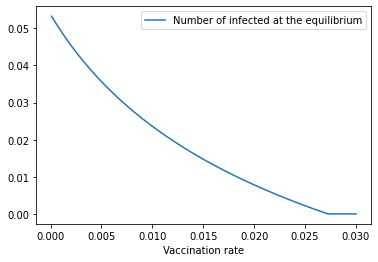

In [30]:
## With nu = cst

x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180

nu = 1 
V_list = np.linspace(0.0001,0.03,10000)
I_list = []

for V in V_list:
  x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*nu)*(1+V/zeta_i)))
  xS = nu/(nu+1)*x_inf
  I_inf = (1-((nu+1)*gamma)/(beta*nu*x_inf**2)*(1+V/zeta_v))/(1+gamma/zeta_i+gamma/eps)
  I_list.append(max(0,I_inf))

plt.figure()
plt.plot(V_list,I_list,label = "Number of infected at the equilibrium")
plt.xlabel("Vaccination rate")
plt.legend()
plt.show()

## Effects of the heterogeneity and vaccination

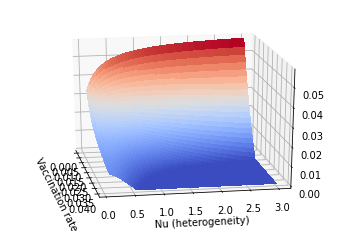

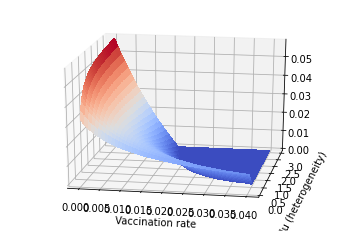

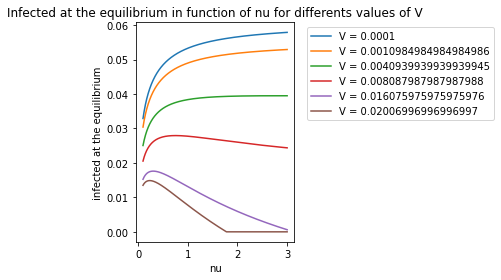

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180

nu = 1 
V_list = np.linspace(0.0001,0.04,1000)
Nu_list = np.linspace(0.1,3,1000)
Vl,Nul = np.meshgrid(V_list,Nu_list)

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*Nul)*(1+Vl/zeta_i)))
xS = Nul/(Nul+1)*x_inf
I_inf = (1-((Nul+1)*gamma)/(beta*Nul*x_inf**2)*(1+Vl/zeta_v))/(1+gamma/zeta_i+gamma/eps)

for i in range(len(I_inf)):
  for j in range(len(I_inf[0])):
    I_inf[i,j]= max(0,I_inf[i,j])

surf = ax.plot_surface(Vl, Nul, I_inf, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel("Vaccination rate")
plt.ylabel("Nu (heterogeneity)")
ax.view_init(20, -10)
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Vl, Nul, I_inf, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel("Vaccination rate")
plt.ylabel("Nu (heterogeneity)")
ax.view_init(20, -80)
plt.show()

plt.figure()
plt.plot(Nu_list,I_inf[:,0],label = "V = "+str(V_list[0]))
plt.plot(Nu_list,I_inf[:,25],label = "V = "+str(V_list[25]))
plt.plot(Nu_list,I_inf[:,100],label = "V = "+str(V_list[100]))
plt.plot(Nu_list,I_inf[:,200],label = "V = "+str(V_list[200]))
plt.plot(Nu_list,I_inf[:,400],label = "V = "+str(V_list[400]))
plt.plot(Nu_list,I_inf[:,500],label = "V = "+str(V_list[500]))
plt.xlabel("nu")
plt.ylabel("infected at the equilibrium")
plt.title("Infected at the equilibrium in function of nu for differents values of V")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()


We can see that there is a threshold which separates 2 behaviors : the number of infected at the equilibrium can increase with $\nu$ or can increase then decrease with $\nu$.

\\

Using the expression of $I^{\infty}$ and looking for a condition to have a negative derivative when $\nu$ goes to the infinity, we find that the condition to have an increase then a decrease is :
\begin{equation}
R_0^{(3)} := \frac{\beta x_0^2 \zeta_v}{\gamma ( V + \zeta_v)} < 1
\end{equation}

\\

So depending on the value of $R_0^{(3)}$, the heterogeneity has not the same impact : if $R_0^{(3)} < 1$ we want to decrease the heterogeneity (i.e increase $\nu$), whereas if $R_0^{(3)} > 1$, we want to increase the heterogeneity (i.e decrease $\nu$).

## Comparaison with the equilibrium when we add asymptomatic individuals.

In the case we add asymptomatic individuals, the endemic equilibrium is defined by the following equations :
\begin{equation}
\left\{ \begin{array}{ll}
R_i^{\infty} = \frac{\gamma_I}{(1-\xi)\zeta_i}I^{\infty} \\
E^{\infty} = \frac{\gamma_I}{(1 - \xi) \epsilon}I^{\infty} \\
S^{\infty} = \frac{\gamma_I}{\beta x_S^{\infty} \left((1 - \xi)x_I^{\infty} + \xi \frac{\gamma_I}{\gamma_A}x_A^{\infty}\right)} \\
R_v^{\infty} = \frac{V \gamma}{\beta \zeta_v x_S^{\infty} \left((1 - \xi)x_I^{\infty} + \xi \frac{\gamma_I}{\gamma_A}x_A^{\infty}\right)}
\end{array} \right.
\end{equation}
and 
\begin{equation}
\left\{ \begin{array}{ll}
x_S^{\infty} = x_{R_v}^{\infty} \\
x_I^{\infty} = x_E^{\infty} = x_{R_i}^{\infty} = x_A^{\infty} \\
x_S^{\infty} = \frac{\nu}{\nu +1} x_I^{\infty}
\end{array} \right.
\end{equation}

with 

\begin{equation}
x_I^{\infty} = \frac{x_0}{2} + \frac{1}{2} \sqrt{x_0^2 + \frac{4 \gamma_I}{\beta \nu \left(1 - \xi + \xi \frac{\gamma_I}{\gamma_A} \right) }\left( 1 + \frac{V}{\zeta_v} \right)}
\end{equation}

and

\begin{equation}
I^{\infty} = \frac{1 - \frac{(\nu + 1) \gamma_I}{{x_I^{\infty}}^2 \beta \nu \left(1 - \xi + \xi \frac{\gamma_I}{\gamma_A} \right)}\left(1 + \frac{V}{\zeta_v} \right)}{1 + \frac{\gamma_I}{(1-\xi)\zeta_i} + \frac{\gamma_I}{\gamma_A} \frac{\xi}{1 - \xi} + \frac{\gamma_I}{(1 - \xi) \epsilon}}
\end{equation}

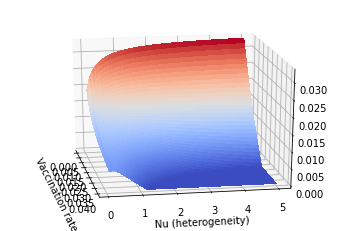

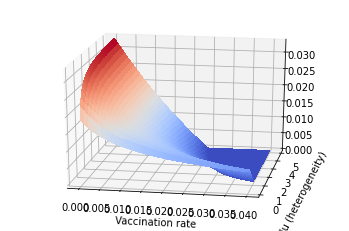

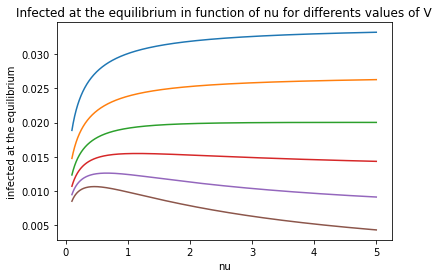

In [32]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x0 = 10 
beta = x_fit_E[0]/x0**2
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180
xi = 0.5
gamma_A = gamma/2

nu = 1 
V_list = np.linspace(0.0001,0.04,1000)
Nu_list = np.linspace(0.1,5,1000)
Vl,Nul = np.meshgrid(V_list,Nu_list)

x_inf = 1/2*(x0 + np.sqrt(x0**2 +4*gamma/(beta*Nul*(1 - xi + xi* gamma/gamma_A))*(1+Vl/zeta_i)))
xS = Nul/(Nul+1)*x_inf
I_inf = (1-((Nul+1)*gamma)/(beta*Nul*x_inf**2*(1-xi+xi*gamma/gamma_A))*(1+Vl/zeta_v))/(1+gamma/((1-xi)*zeta_i)+gamma/((1-xi)*eps)+xi*gamma/((1-xi)*gamma_A))

for i in range(len(I_inf)):
  for j in range(len(I_inf[0])):
    I_inf[i,j]= max(0,I_inf[i,j])

surf = ax.plot_surface(Vl, Nul, I_inf, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel("Vaccination rate")
plt.ylabel("Nu (heterogeneity)")
ax.view_init(20, -10)
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Vl, Nul, I_inf, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel("Vaccination rate")
plt.ylabel("Nu (heterogeneity)")
ax.view_init(20, -80)
plt.show()

plt.figure()
plt.plot(Nu_list,I_inf[:,0],label = "V = "+str(V_list[0]))
plt.plot(Nu_list,I_inf[:,100],label = "V = "+str(V_list[100]))
plt.plot(Nu_list,I_inf[:,200],label = "V = "+str(V_list[200]))
plt.plot(Nu_list,I_inf[:,300],label = "V = "+str(V_list[300]))
plt.plot(Nu_list,I_inf[:,400],label = "V = "+str(V_list[400]))
plt.plot(Nu_list,I_inf[:,500],label = "V = "+str(V_list[500]))
plt.xlabel("nu")
plt.ylabel("infected at the equilibrium")
plt.title("Infected at the equilibrium in function of nu for differents values of V")
plt.show()

## Saturated Incidence rate

We can conjecture that if $R_0^{(1)} < 1$, then the solution will reach a disease-free equilibrium, and if if $R_0^{(1)} > 1$, the solution will reach an endemic equilibrium. However, the stability of these equilibriums is too difficult to prove because we have too many equations (10 equations). \\
In order to reduce the difficulty, we can freeze the mean number of contacts of infected to $\tilde{x}_I$, as in the initial article (quarantine), to try to obtain the following system :

\begin{equation} 
\left\{ \begin{array}{ll}
\frac{\partial S}{\partial t} = -\beta H(I(t),t) I(t)S(t) + \zeta_i R_i(t) + \zeta_v R_v(t) - VS(t) \\
\frac{\partial E}{\partial t} = \beta H(I(t),t) I(t)S(t) - \epsilon E(t)  \\
\frac{\partial I}{\partial t} = \epsilon E(t) - \gamma I(t) \\
\frac{\partial R_i}{\partial t} = \gamma I(t) - \zeta_i R_i(t) \\
\frac{\partial R_v}{\partial t} = V S(t) - \zeta_v R_v(t)
\end{array} \right.
\end{equation}
\
So if we find $H$, we pass from a $10$ equations system to a $5$ equations system.
\
\
Remark : as we included reinfection in our model, we assume that once people get infected, they reduce their mean number of contacts forever.

Unfortunately, it is too difficult to find $H$ because we have to solve a differential equation with the following shape : $y'(t) = a(t)y^2(t) + b(t)y(t) + c(t)$.
\
\
However, we can compute numerically the saturated incidence rate $H$ to see the effect of the vaccination.

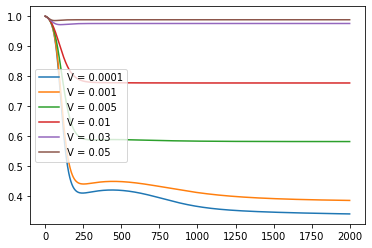

In [33]:
x0 = 10 
beta = x_fit_E[0]/(x0*5)
gamma = x_fit_E[2]
eps = x_fit_E[1]
zeta_i = 1/180
zeta_v = 1/180

xtilde = 5

i0 = Inf[-1]
e0 = Inf[-1]
ri0 = ri0 = np.sum(pos_data_moyenne[-180:])
rv0 = 8/67
s0=1-i0-e0-ri0-rv0

nu = 1 
V_list = [0.0001,0.001,0.005,0.01,0.03,0.05]

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,2000,2000)
plt.figure()
for V in V_list:
  f = lambda y,t : np.array([-beta * y[5]*xtilde*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*xtilde*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*xtilde*y[2]+zeta_i*y[3]/y[0]*(y[6]-y[5]) + zeta_v * y[4]/y[0]*(y[7]-y[5]),gamma * y[2]/y[3]*(xtilde-y[6]),V*y[0]/y[4]*(y[5]-y[7])])
  y = odeint(f,CI,t)
  plt.plot(t,y[:,5]/x0,label = "V = "+str(V))
plt.legend()
plt.show()


We can see that the vaccination reduce the impact of a quarantine strategy, so if we vaccinate enough, we do not need to use a quarantine strategy.

We can now compare the shape of the epidemic including or not the quarantine strategy.

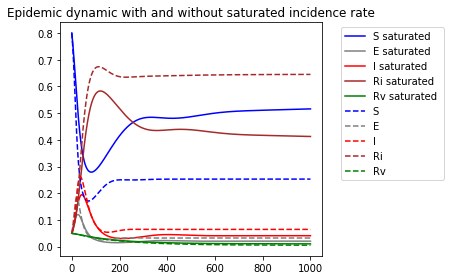

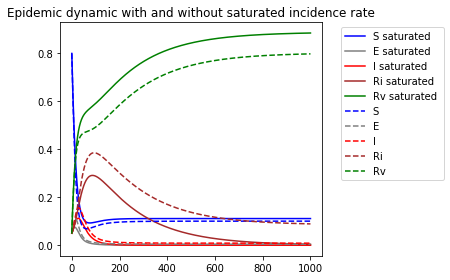

In [34]:
x0 = 10
beta = 0.3/x0**2
gamma = 0.05
eps = 2*gamma
zeta_i = gamma/10
zeta_v = gamma/10

nu = 1
s0 = 0.8
i0 = 0.05
e0 = 0.05
ri0 = 0.05
rv0 = 0.05

xtilde = 8


nu = 1 
V = 0.0001

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,1000,2000)
plt.figure()
f = lambda y,t : np.array([-beta * y[5]*xtilde*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*xtilde*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*xtilde*y[2]+zeta_i*y[3]/y[0]*(y[6]-y[5]) + zeta_v * y[4]/y[0]*(y[7]-y[5]),gamma * y[2]/y[3]*(xtilde-y[6]),V*y[0]/y[4]*(y[5]-y[7])])
y = odeint(f,CI,t)

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])



Y = odeint(f,CI,t)

s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]

plt.plot(t,y[:,0],color = 'blue',label = "S saturated")
plt.plot(t,y[:,1],color = 'grey',label = "E saturated")
plt.plot(t,y[:,2],color = 'red',label = "I saturated")
plt.plot(t,y[:,3],color = 'brown',label = "Ri saturated")
plt.plot(t,y[:,4],color = 'green',label = "Rv saturated ")
plt.plot(t,s,color = 'blue', linestyle = '--',label = "S")
plt.plot(t,e,color = 'grey', linestyle = '--',label = "E")
plt.plot(t,i,color = 'red', linestyle = '--',label = "I")
plt.plot(t,ri,color = 'brown', linestyle = '--',label = "Ri")
plt.plot(t,rv,color = 'green', linestyle = '--',label = "Rv")
plt.title("Epidemic dynamic with and without saturated incidence rate")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()


V = 0.04

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,1000,2000)
plt.figure()
f = lambda y,t : np.array([-beta * y[5]*xtilde*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*xtilde*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*xtilde*y[2]+zeta_i*y[3]/y[0]*(y[6]-y[5]) + zeta_v * y[4]/y[0]*(y[7]-y[5]),gamma * y[2]/y[3]*(xtilde-y[6]),V*y[0]/y[4]*(y[5]-y[7])])
y = odeint(f,CI,t)

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])



Y = odeint(f,CI,t)

s,e,i,ri,rv,xs,xe,xi,xri,xrv = Y[:,0],Y[:,1],Y[:,2],Y[:,3],Y[:,4],Y[:,5],Y[:,6],Y[:,7],Y[:,8],Y[:,9]

plt.plot(t,y[:,0],color = 'blue',label = "S saturated")
plt.plot(t,y[:,1],color = 'grey',label = "E saturated")
plt.plot(t,y[:,2],color = 'red',label = "I saturated")
plt.plot(t,y[:,3],color = 'brown',label = "Ri saturated")
plt.plot(t,y[:,4],color = 'green',label = "Rv saturated ")
plt.plot(t,s,color = 'blue', linestyle = '--',label = "S")
plt.plot(t,e,color = 'grey', linestyle = '--',label = "E")
plt.plot(t,i,color = 'red', linestyle = '--',label = "I")
plt.plot(t,ri,color = 'brown', linestyle = '--',label = "Ri")
plt.plot(t,rv,color = 'green', linestyle = '--',label = "Rv")
plt.title("Epidemic dynamic with and without saturated incidence rate")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

## Comparaison H : Model with Rv and Ri but no E

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

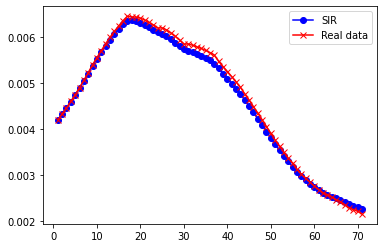

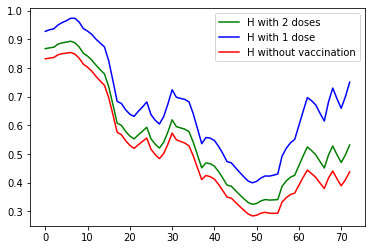

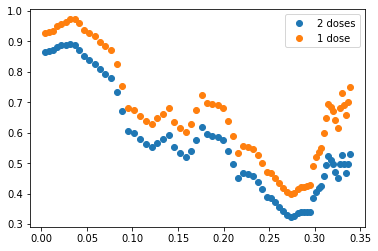

In [35]:
zeta_i = 1/180
zeta_v = 1/180
V = V_estimation2

x_H = np.array([])

t0 = 310
tf = 383
db = 1
da = 2

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  beta = x_fit[0]
  gamma = x_fit[1]
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[1]*H[0] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H[0] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
      y0 = np.array([1-Inf_Rec[d-db]-data.loc[844-85+d-t0-db,"n_cum_dose2"]/67000000,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844-85+d-t0-db,"n_cum_dose2"]/67000000])
      y = np.zeros((4,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,i1 = y[0,:],y[1,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,2)]))
  x_H =np.concatenate((x_H,res.x))

H = x_H

t = np.linspace(0,tf-t0,tf-t0+1)

f = lambda y , t : np.array([-beta*y[0]*y[1]*H[int(t)] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H[int(t)] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
y0 = np.array([1-Inf_Rec[t0]-data.loc[844-85,"n_cum_dose2"]/67000000,Inf[t0],Inf_Rec[t0] - Inf[t0],data.loc[844-85,"n_cum_dose2"]/67000000])
y = np.zeros((4,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]

x_H1 = np.array([])

t0 = 310
tf = 383
db = 1
da = 2
V = V_estimation1

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  beta = x_fit[0]
  gamma = x_fit[1]
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[1]*H[0] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H[0] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
      y0 = np.array([1-Inf_Rec[d-db]-data.loc[844-85+d-t0-db,"n_cum_dose1"]/67000000,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844-85+d-t0-db,"n_cum_dose1"]/67000000])
      y = np.zeros((4,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,i1 = y[0,:],y[1,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,2)]))
  x_H1 =np.concatenate((x_H1,res.x))

H1 = x_H1

t = np.linspace(0,tf-t0,tf-t0+1)

f = lambda y , t : np.array([-beta*y[0]*y[1]*H1[int(t)] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H1[int(t)] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
y0 = np.array([1-Inf_Rec[t0]-data.loc[844-85,"n_cum_dose1"]/67000000,Inf[t0],Inf_Rec[t0] - Inf[t0],data.loc[844-85,"n_cum_dose1"]/67000000])
y = np.zeros((4,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]

plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1[:tf-t0-2],"b-o",label = "SIR")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:-1],H,"green",label = "H with 2 doses")
plt.plot(t[:-1],H1,"blue",label = "H with 1 dose")
plt.plot(t[:-1],H_3,"red",label = "H without vaccination")
plt.legend()
plt.show()

Inf_cum = [Inf[t0]]

for k in range(t0,tf):
  Inf_cum.append(Inf_cum[-1]+Inf[k])

plt.figure(3)
plt.plot(Inf_cum[:-1],H,"o",label = "2 doses")
plt.plot(Inf_cum[:-1],H1,"o",label = "1 dose")
plt.legend()
plt.show()

H2 = H

Now we can use the $H$ of the model with vaccination in the case of the $SIR$ model to see what could be happened if we did not vaccinate.

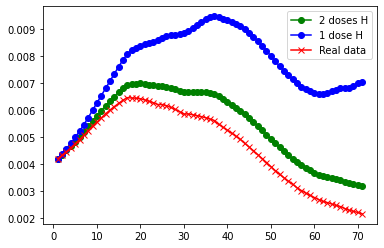

In [36]:
t = np.linspace(0,tf-t0,tf-t0+1)

f = lambda y , t : np.array([-beta*y[0]*y[1]*H[int(t)],beta*y[0]*y[1]*H[int(t)] - gamma * y[1]])
y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
y = np.zeros((2,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_2,i1_2 = y[0,:],y[1,:]

f = lambda y , t : np.array([-beta*y[0]*y[1]*H1[int(t)],beta*y[0]*y[1]*H1[int(t)] - gamma * y[1]])
y0 = np.array([1-Inf_Rec[t0],Inf[t0]])
y = np.zeros((2,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_1,i1_1 = y[0,:],y[1,:]

plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1_2[:tf-t0-2],"g-o",label = "2 doses H")
plt.plot(t[1:tf-t0-1:],i1_1[:tf-t0-2],"b-o",label = "1 dose H")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

Now we add E

In [37]:
x_H_E2 = np.array([])

t0 = 310
tf = 383
db = 1
da = 5

beta = x_fit_E[0]
epsilon = x_fit_E[1]
gamma = x_fit_E[2]
e0 = E0_guess
V = V_estimation2

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[2]*H[0]+ zeta_v*y[4] + zeta_i*y[3] - V*y[0],beta*y[0]*y[2]*H[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
      y0 = np.array([1-Inf_Rec[d-db]-data.loc[844+d-t0-db-85,"n_cum_dose2"]/67000000-e0,e0,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844+d-t0-db-85,"n_cum_dose2"]/67000000])
      y = np.zeros((5,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,e1,i1 = y[0,:],y[1,:],y[2,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,2)]))
  x_H_E2 =np.concatenate((x_H_E2,res.x))
  f = lambda y , t : np.array([-beta*y[0]*y[2]*res.x[0] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[2]*res.x[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
  y0 = np.array([1-Inf_Rec[d-db]-data.loc[844+d-t0-db-85,"n_cum_dose2"]/67000000-e0,e0,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844+d-t0-db-85,"n_cum_dose2"]/67000000])
  y = np.zeros((5,db+da+1))
  y[:,0] = y0
  for k in range(1,db+da+1):
    k1 = f(y[:,k-1],t[k-1])
    k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
    k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
    k4 = f(y[:,k-1]+k3,t[k-1]+1)
    y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
  s1,e1,i1 = y[0,:],y[1,:],y[2,:]
  e0 = e1[1]

x_H_E1 = np.array([])

t0 = 310
tf = 383
db = 1
da = 5

beta = x_fit_E[0]
epsilon = x_fit_E[1]
gamma = x_fit_E[2]
e0 = E0_guess
V = V_estimation1

for d in range(t0,tf):
  t = np.linspace(0,db+da,db+da+1)
  N = 67000000
  def solve_H(H):
      f = lambda y , t : np.array([-beta*y[0]*y[2]*H[0]+ zeta_v*y[4] + zeta_i*y[3] - V*y[0],beta*y[0]*y[2]*H[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
      y0 = np.array([1-Inf_Rec[d-db]-data.loc[844+d-t0-db-85,"n_cum_dose1"]/67000000-e0,e0,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844+d-t0-db-85,"n_cum_dose1"]/67000000])
      y = np.zeros((5,db+da+1))
      y[:,0] = y0
      for k in range(1,db+da+1):
        k1 = f(y[:,k-1],t[k-1])
        k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
        k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
        k4 = f(y[:,k-1]+k3,t[k-1]+1)
        y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
      s1,e1,i1 = y[0,:],y[1,:],y[2,:]
      n1=0
      n2=0
      v1=0
      v2=0
      for i in range(db+da+1):
          n1+=(Inf_Rec[d-db +i]-(1-s1[i]-e1[i]))**2
          v1+=Inf_Rec[d-db +i]**2
          n2+=(Inf[d-db+i]-i1[i])**2
          v2+=Inf[d-db+i]**2
      return 10000*(0.95*np.sqrt(n2/v2) + 0.05*np.sqrt(n1/v1))
  res = minimize(solve_H,[0.5],method = 'trust-constr',bounds = ([(0,2)]))
  x_H_E1 =np.concatenate((x_H_E1,res.x))
  f = lambda y , t : np.array([-beta*y[0]*y[2]*res.x[0] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[2]*res.x[0] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
  y0 = np.array([1-Inf_Rec[d-db]-data.loc[844+d-t0-db-85,"n_cum_dose1"]/67000000-e0,e0,Inf[d-db],Inf_Rec[d-db] - Inf[d-db],data.loc[844+d-t0-db-85,"n_cum_dose1"]/67000000])
  y = np.zeros((5,db+da+1))
  y[:,0] = y0
  for k in range(1,db+da+1):
    k1 = f(y[:,k-1],t[k-1])
    k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
    k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
    k4 = f(y[:,k-1]+k3,t[k-1]+1)
    y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
  s1,e1,i1 = y[0,:],y[1,:],y[2,:]
  e0 = e1[1]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

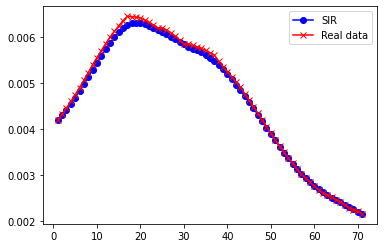

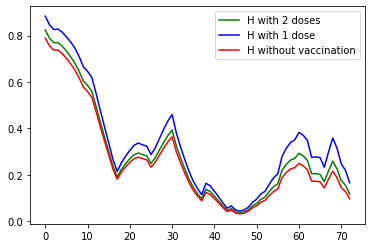

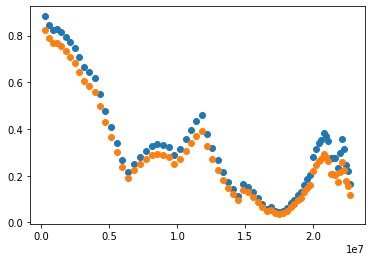

In [38]:
H_EV1 = x_H_E1
H_EV2 = x_H_E2

V = V_estimation2

t = np.linspace(0,tf-t0,tf-t0+1)

e0 = E0_guess

f = lambda y , t : np.array([-beta*y[0]*y[2]*H_EV2[int(t)]+ zeta_v*y[4] + zeta_i*y[3] - V*y[0],beta*y[0]*y[2]*H_EV2[int(t)] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
y0 = np.array([1-Inf_Rec[t0]-data.loc[844-85,"n_cum_dose2"]/67000000-e0,e0,Inf[t0],Inf_Rec[t0] - Inf[t0],data.loc[844-85,"n_cum_dose2"]/67000000])
y = np.zeros((5,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_2,e1_2,i1_2 = y[0,:],y[1,:],y[2,:]

V = V_estimation1

f = lambda y , t : np.array([-beta*y[0]*y[2]*H_EV1[int(t)]+ zeta_v*y[4] + zeta_i*y[3] - V*y[0],beta*y[0]*y[2]*H_EV1[int(t)] - epsilon * y[1],epsilon*y[1]-gamma*y[2],gamma*y[2]-zeta_i*y[3],V*y[0]-zeta_v*y[4]])
y0 = np.array([1-Inf_Rec[t0]-data.loc[844-85,"n_cum_dose1"]/67000000-e0,e0,Inf[t0],Inf_Rec[t0] - Inf[t0],data.loc[844-85,"n_cum_dose1"]/67000000])
y = np.zeros((5,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_1,e1_1,i1_1 = y[0,:],y[1,:],y[2,:]

plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1_2[:tf-t0-2],"b-o",label = "SIR")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:-1],H_EV2,"green",label = "H with 2 doses")
plt.plot(t[:-1],H_EV1,"blue",label = "H with 1 dose")
plt.plot(t[:-1],H_E,"red",label = "H without vaccination")
plt.legend()
plt.show()

Inf_cum = [Inf[t0]]

for k in range(t0,tf):
  Inf_cum.append(Inf_cum[-1]+Inf[k])

plt.figure(3)
plt.plot(N*np.array(Inf_cum[:-1]),H_EV1,"o",label = "1 dose")
plt.plot(N*np.array(Inf_cum[:-1]),H_EV2,"o", label = "2 doses")
plt.show()

Now we can use the  H  of the model with vaccination in the case of the  SEIR  model to see what could be happened if we did not vaccinate.

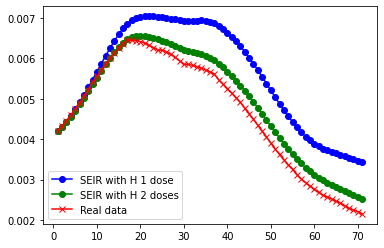

In [39]:
t = np.linspace(0,tf-t0,tf-t0+1)

V = V_estimation2

f = lambda y , t : np.array([-beta*y[0]*y[2]*H_EV2[int(t)],beta*y[0]*y[2]*H_EV2[int(t)] - epsilon * y[1],epsilon*y[1]-gamma*y[2]])
y0 = np.array([1-Inf_Rec[t0]-E0_guess,E0_guess,Inf[t0]])
y = np.zeros((3,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_2,e1_2,i1_2 = y[0,:],y[1,:],y[2,:]

V = V_estimation1

f = lambda y , t : np.array([-beta*y[0]*y[2]*H_EV1[int(t)],beta*y[0]*y[2]*H_EV1[int(t)] - epsilon * y[1],epsilon*y[1]-gamma*y[2]])
y0 = np.array([1-Inf_Rec[t0]-E0_guess,E0_guess,Inf[t0]])
y = np.zeros((3,tf-t0))
y[:,0] = y0
for k in range(1,tf-t0-2):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1_1,e1_1,i1_1 = y[0,:],y[1,:],y[2,:]

plt.figure(1)
plt.plot(t[1:tf-t0-1:],i1_1[:tf-t0-2],"b-o",label = "SEIR with H 1 dose")
plt.plot(t[1:tf-t0-1:],i1_2[:tf-t0-2],"g-o",label = "SEIR with H 2 doses")
plt.plot(t[1:tf-t0-1:],Inf[t0:tf-2],"r-x",label="Real data")
plt.legend()
plt.show()

## Extrapolation of H

We can assume that $H(r,t)$ can be written as :
\begin{equation}
H(r(t),t) = \frac{1}{(1 + ar(t))^b}
\end{equation}
\
We will use $r(t) = N I(t) \sum_{s \leq t} I(s)$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


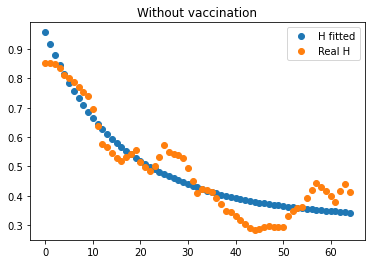

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power


a = 2.2176537100044697e-07 and b = 0.6231443426263947


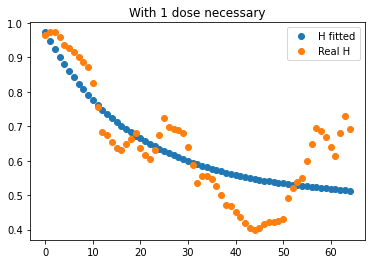

a = 2.2018510054736865e-07 and b = 0.389292792806028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in power


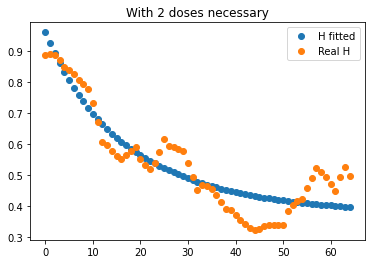

a = 2.369585708122711e-07 and b = 0.5200778209089162


In [40]:
start = 5
end = 70

H = np.array(H_3)[start:end]
N = 67000000
R = [Inf[t0+start]]
for k in range(start+1,end):
  R.append(R[-1]+Inf[t0+k])
R = N*np.array(R)

t = np.linspace(0,len(H)-1,len(H))

def fit_H(x):
  a = x[0]
  b = x[1]
  f = lambda r : 1/(1+a*r)**b
  return np.sum((H - f(R))**2)

res = minimize(fit_H,[1,1],method = "Nelder-Mead")
H_fit = res.x
a = H_fit[0]
b = H_fit[1]


f = lambda r : 1/(1+a*r)**b
H_model = f(R)
plt.figure()
plt.plot(t,H_model,"o",label = "H fitted")
plt.plot(t,H,"o", label = "Real H")
plt.title("Without vaccination")
plt.legend()
plt.show()
print("a = "+str(a)+" and b = "+str(b))

H = np.array(H1)[start:end]


def fit_H(x):
  a = x[0]
  b = x[1]
  f = lambda r : 1/(1+a*r)**b
  return np.sum((H - f(R))**2)

res = minimize(fit_H,[1,1],method = "Nelder-Mead")
H_fit = res.x
a = H_fit[0]
b = H_fit[1]


f = lambda r : 1/(1+a*r)**b
H_model1 = f(R)
plt.figure()
plt.plot(t,H_model1,"o",label = "H fitted")
plt.plot(t,H,"o", label = "Real H")
plt.title("With 1 dose necessary")
plt.legend()
plt.show()
print("a = "+str(a)+" and b = "+str(b))

H = np.array(H2)[start:end]

def fit_H(x):
  a = x[0]
  b = x[1]
  f = lambda r : 1/(1+a*r)**b
  return np.sum((H - f(R))**2)

res = minimize(fit_H,[1,1],method = "Nelder-Mead")
H_fit = res.x
a = H_fit[0]
b = H_fit[1]


f = lambda r : 1/(1+a*r)**b
H_model2 = f(R)
plt.figure()
plt.plot(t,H_model2,"o",label = "H fitted")
plt.plot(t,H,"o", label = "Real H")
plt.title("With 2 doses necessary")
plt.legend()
plt.show()
print("a = "+str(a)+" and b = "+str(b))



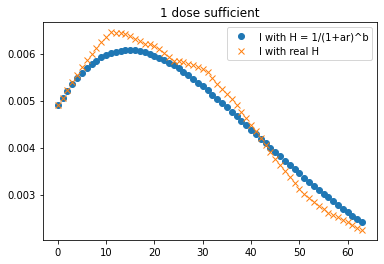

4.74859067346538


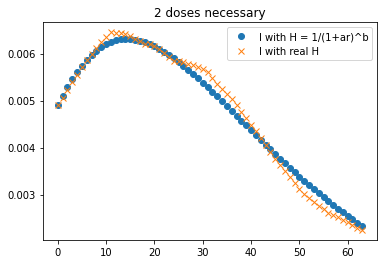

2.8112123488803733


In [41]:
beta = x_fit[0]
gamma = x_fit[1]

t = np.linspace(0,end-start-1,end-start)

H = H_model1
V = V_estimation1

f = lambda y , t : np.array([-beta*y[0]*y[1]*H[int(t)] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H[int(t)] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
y0 = np.array([1-Inf_Rec[t0+start]-data.loc[844-85+start,"n_cum_dose1"]/67000000,Inf[t0+start],Inf_Rec[t0+start] - Inf[t0+start],data.loc[844-85+start,"n_cum_dose1"]/67000000])
y = np.zeros((4,end-start))
y[:,0] = y0
for k in range(1,end - start - 1):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]

plt.figure()
plt.plot(t[:-1],i1[:-1],"o",label = "I with H = 1/(1+ar)^b")
plt.plot(t[:-1],Inf[t0+start : t0 + end-1],"x",label = "I with real H")
plt.title("1 dose sufficient")
plt.legend()
plt.show()

print(np.sum(np.abs(i1[:-1]-Inf[t0+start : t0 + end-1])/np.sum(Inf[t0+start : t0 + end-1]))*100)

t = np.linspace(0,end-start-1,end-start)

H = H_model2
V = V_estimation2

f = lambda y , t : np.array([-beta*y[0]*y[1]*H[int(t)] + zeta_v*y[3] + zeta_i*y[2] - V*y[0],beta*y[0]*y[1]*H[int(t)] - gamma * y[1],gamma*y[1] - zeta_i * y[2],V*y[0] - zeta_v*y[3]])
y0 = np.array([1-Inf_Rec[t0+start]-data.loc[844-85+start,"n_cum_dose2"]/67000000,Inf[t0+start],Inf_Rec[t0+start] - Inf[t0+start],data.loc[844-85+start,"n_cum_dose2"]/67000000])
y = np.zeros((4,end-start))
y[:,0] = y0
for k in range(1,end - start - 1):
  k1 = f(y[:,k-1],t[k-1])
  k2 = f(y[:,k-1]+k1/2,t[k-1]+1/2)
  k3 = f(y[:,k-1]+k2/2,t[k-1]+1/2)
  k4 = f(y[:,k-1]+k3,t[k-1]+1)
  y[:,k] = y[:,k-1] +1/6*(k1+2*k2+2*k3+k4)
s1,i1 = y[0,:],y[1,:]

plt.figure()
plt.plot(t[:-1],i1[:-1],"o",label = "I with H = 1/(1+ar)^b")
plt.plot(t[:-1],Inf[t0+start : t0 + end-1],"x",label = "I with real H ")
plt.title("2 doses necessary")
plt.legend()
plt.show()

print(np.sum(np.abs(i1[:-1]-Inf[t0+start : t0 + end-1])/np.sum(Inf[t0+start : t0 + end-1]))*100)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


[0.97709995 0.9552179  0.93433189 0.91441584 0.89545264 0.87739364
 0.86021718 0.84390463 0.82844067 0.81381186 0.7999974  0.78696293
 0.77468635 0.76314957 0.75232995 0.74220267 0.73275433 0.72397254
 0.71572202 0.70800827 0.70081812 0.69413248 0.6879405  0.68223993
 0.67702844 0.6723686  0.66820835 0.66452667 0.66130655 0.65853323
 0.65620212 0.65430943 0.6528382  0.65177968 0.65113002 0.65088412
 0.65103682 0.65158414 0.65252578 0.6538531  0.65555961 0.65763522
 0.66006349 0.66284197 0.66594199 0.66936434 0.67311109 0.67717887
 0.68156384 0.686265   0.69128102 0.69661061 0.70225259 0.70820379
 0.71448149 0.72109145 0.72801166 0.73525596 0.74283185 0.75072982]


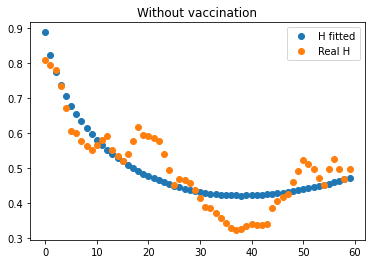

a = 3.016776728143754e-06 and b = 0.12340247107443236 and alpha = 230.41490468343926 and delta = -379.34778564374153


In [42]:
start = 12
end = 72

H = np.array(H2)[start:end]
N = 67000000
Ri_S = [(Inf_Rec[t0+start]-Inf[t0+start])/(1-Inf_Rec[t0+start]-data.loc[844-85+start,"n_cum_dose2"]/67000000 )]
Rv_S = [(data.loc[844-85+start,"n_cum_dose2"]/67000000)/(1-Inf_Rec[t0+start]-data.loc[844-85+start,"n_cum_dose2"]/67000000 )]
for k in range(start+1,end):
  Ri_S.append(Ri_S[-1]+(Inf_Rec[t0+k]-Inf[t0+k])/(1-Inf_Rec[t0+k]-data.loc[844-85+k,"n_cum_dose2"]/67000000 ))
  Rv_S.append(Rv_S[-1]+(data.loc[844-85+start,"n_cum_dose2"]/67000000)/(1-Inf_Rec[t0+k]-data.loc[844-85+k,"n_cum_dose2"]/67000000 ))
Ri_S = np.array(Ri_S)
Rv_S = np.array(Rv_S)


t = np.linspace(0,len(H)-1,len(H))

def fit_H(x):
  a = x[0]
  b = x[1]
  alpha = x[2]
  delta = x[3]
  f_a = np.exp((alpha-1)* zeta_i * Ri_S)*np.exp((delta - 1)* zeta_v*Rv_S)
  Icum = [Inf[t0+start]*f_a[0]]
  for k in range(start+1,end):
    Icum.append(Icum[-1]+Inf[t0+k]*f_a[k-start])
  Icum = N*np.array(Icum)
  f_H = f_a/(1+a*Icum)**b
  return 1000*np.sum((H2[start:end] - f_H)**2)

res = minimize(fit_H,[3.1831374814365847e-07,0.44797473165385704,0.5,2],method = "Nelder-Mead",bounds = [(None,None),(None,None),(0.,None),(0.,None)])
x = res.x
a = x[0]
b = x[1]
alpha = x[2]
delta = x[3]
f_a = np.exp((alpha-1)* zeta_i * Ri_S)*np.exp((delta - 1)* zeta_v*Rv_S)
print(f_a)
Icum = [Inf[t0+start]*f_a[0]]
for k in range(start+1,end):
  Icum.append(Icum[-1]+Inf[t0+k]*f_a[k-start])
Icum = np.array(Icum)
H_model = f_a/(1+a*N*Icum)**b
plt.figure()
plt.plot(t,H_model,"o",label = "H fitted")
plt.plot(t,H,"o", label = "Real H")
plt.title("Without vaccination")
plt.legend()
plt.show()
print("a = "+str(a)+" and b = "+str(b)+" and alpha = "+str(alpha)+" and delta = "+str(delta))







---

---



## Calibration to fit $\nu$

---

Using data from the third wave

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:454: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


nu = 1.0
[0.1 0.1 0.1 1. ]
R0 = 137.2654155496129


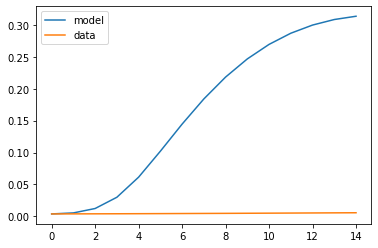

In [43]:

t0 = 305
tf = 320
x0 = 10
zeta_i = 1/180
zeta_v = 1/180


i0 = Inf[t0]
e0 = E0_guess
ri0 = Inf_Rec[t0]
rv0 = data_vaccine.loc[844-85,"n_cum_dose2"]/67000000
s0 = 1 - i0 - e0 - ri0 - rv0


V = V_estimation2

Y0 = np.array([s0,e0,i0,ri0,rv0])
X0 = np.array([x0,x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,tf-t0-1,tf-t0)

def solve_nu(x):
  beta = x[0]
  eps = x[1]
  gamma = x[2]
  nu = x[3]
  f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])
  Y = odeint(f,CI,t)
  i = Y[:,2]
  n2=0
  for k in range(len(i)):
      n2+=(Inf[t0+k]-i[k])**2
  return 1000*n2
res = minimize(solve_nu,[0.1,0.1,0.1,1],method = 'trust-constr',bounds = [(0.,1),(1/7,1/3),(1/20,1/5),(0.1,10)])
print("nu = "+str(res.x[3]))


nu_fit = res.x

print(nu_fit)


x0 = 10
beta = nu_fit[0]
gamma = nu_fit[2]
eps = nu_fit[1]
zeta_i = 1/180
zeta_v = 1/180


i0 = Inf[t0]
e0 = E0_guess
ri0 = Inf_Rec[t0]
rv0 = data_vaccine.loc[844-85,"n_cum_dose2"]/67000000
s0 = 1 - i0 - e0 - ri0 - rv0
nu = nu_fit[3]

f = lambda y,t : np.array([-beta * y[5]*y[7]*y[0]*y[2] +zeta_i*y[3]+zeta_v*y[4]-V*y[0], beta * y[5]*y[7]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], V*y[0] - zeta_v*y[4],-beta/nu*y[5]**2*y[7]*y[2]+zeta_i*y[3]/y[0]*(y[8]-y[5]) + zeta_v * y[4]/y[0]*(y[9]-y[5]), beta * y[5]*y[7]*y[2]*y[0]/y[1]*((nu+1)/nu*y[5] - y[6]),eps * y[1]/y[2]*(y[6]-y[7]),gamma * y[2]/y[3]*(y[7]-y[8]),V*y[0]/y[4]*(y[5]-y[9])])
Y = odeint(f,CI,t)
i = Y[:,2]



plt.plot(t,i,label="model")
plt.plot(t,Inf[t0:tf],label = "data")
plt.legend()

R0 = beta*(nu+1)*x0**2*zeta_v/(gamma*nu*(zeta_v+V))

print("R0 = " + str(R0))

Using data from the 2nd wave.

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/pytho

nu = 8.860960430874021
[1.52266339e-03 1.42890881e-01 5.24832103e-02 8.86096043e+00]
R0 = 3.2286571727250166


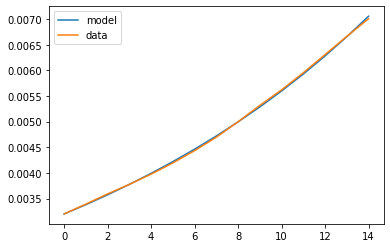

In [44]:
t0 = 155
tf = 170
x0 = 10
zeta_i = 1/180



i0 = Inf[t0]
e0 = E0_guess_2
ri0 = Inf_Rec[t0]
s0 = 1 - i0 - e0 - ri0 



Y0 = np.array([s0,e0,i0,ri0])
X0 = np.array([x0,x0,x0,x0])
CI = np.concatenate((Y0,X0))
t = np.linspace(0,tf-t0-1,tf-t0)

def solve_nu(x):
  beta = x[0]
  eps = x[1]
  gamma = x[2]
  nu = x[3]
  f = lambda y,t : np.array([-beta * y[4]*y[6]*y[0]*y[2] +zeta_i*y[3], beta * y[4]*y[6]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], -beta/nu*y[4]**2*y[6]*y[2]+zeta_i*y[3]/y[0]*(y[7]-y[6]), beta * y[4]*y[6]*y[2]*y[0]/y[1]*((nu+1)/nu*y[4] - y[5]),eps * y[1]/y[2]*(y[5]-y[6]),gamma * y[2]/y[3]*(y[6]-y[7])])
  Y = odeint(f,CI,t)
  i = Y[:,2]
  n2=0
  for k in range(len(i)):
      n2+=(Inf[t0+k]-i[k])**2
  return 1000*n2
res = minimize(solve_nu,[0.1,0.1,0.1,1],method = 'trust-constr',bounds = [(0.,1),(1/7,1/3),(1/20,1/5),(0.1,10)])
print("nu = "+str(res.x[3]))


nu_fit = res.x

print(nu_fit)


x0 = 10
beta = nu_fit[0]
gamma = nu_fit[2]
eps = nu_fit[1]
zeta_i = 1/180



i0 = Inf[t0]
e0 = E0_guess_2
ri0 = Inf_Rec[t0]
s0 = 1 - i0 - e0 - ri0 
nu = nu_fit[3]

f = lambda y,t : np.array([-beta * y[4]*y[6]*y[0]*y[2] +zeta_i*y[3], beta * y[4]*y[6]*y[0]*y[2] -eps*y[1],eps*y[1] - gamma*y[2], gamma*y[2] - zeta_i*y[3], -beta/nu*y[4]**2*y[6]*y[2]+zeta_i*y[3]/y[0]*(y[7]-y[6]), beta * y[4]*y[6]*y[2]*y[0]/y[1]*((nu+1)/nu*y[4] - y[5]),eps * y[1]/y[2]*(y[5]-y[6]),gamma * y[2]/y[3]*(y[6]-y[7])])
Y = odeint(f,CI,t)
i = Y[:,2]



plt.plot(t,i,label="model")
plt.plot(t,Inf[t0:tf],label = "data")
plt.legend()

R0 = beta*(nu+1)*x0**2/(gamma*nu)

print("R0 = " + str(R0))

# Analysis taking into account age

## Data of infected

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


430


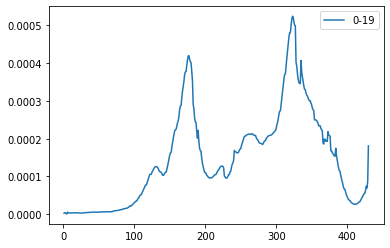

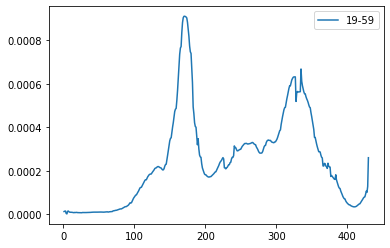

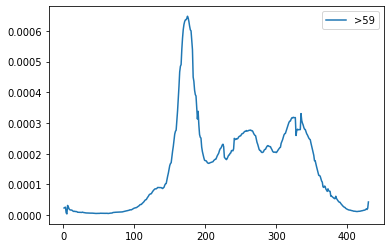

[16099691.84681013 33157720.04768451 17857583.10550537]


In [45]:
data = pd.read_csv ('data_clage.csv', delimiter=";")

n = len(data.loc[(data["cl_age90"] == 9) & (data["dep"] == 2),:])

D_cases = np.empty((3,n))  #3 classes of age : 0-19 ; 19 - 59 ; > 59

dates = data.loc[(data["cl_age90"] == 9) & (data["dep"] == 1),"jour"]

N_people = np.empty(3)

print(n)

for k in range(n):
  D_cases[0,k] = data.loc[((data["cl_age90"] == 9) | (data["cl_age90"] == 19)) & (data["jour"] == dates.iloc[k]),"P"].sum()

N_people[0] = data.loc[((data["cl_age90"] == 9) | (data["cl_age90"] == 19)) & (data["jour"] == dates.iloc[0]),"pop"].sum()

for k in range(n):
  D_cases[1,k] = data.loc[((data["cl_age90"] == 29) | (data["cl_age90"] == 39) | (data["cl_age90"] == 49) | (data["cl_age90"] == 59)) & (data["jour"] == dates.iloc[k]),"P"].sum()

N_people[1] = data.loc[((data["cl_age90"] == 29) | (data["cl_age90"] == 39) | (data["cl_age90"] == 49) | (data["cl_age90"] == 59)) & (data["jour"] == dates.iloc[0]),"pop"].sum()

for k in range(n):
  D_cases[2,k] = data.loc[((data["cl_age90"] == 69) | (data["cl_age90"] == 79) | (data["cl_age90"] == 89) | (data["cl_age90"] == 90)) & (data["jour"] == dates.iloc[k]),"P"].sum()

N_people[2] = data.loc[((data["cl_age90"] == 69) | (data["cl_age90"] == 79) | (data["cl_age90"] == 89) | (data["cl_age90"] == 90)) & (data["jour"] == dates.iloc[0]),"pop"].sum()

D_cases_smooth = np.empty((3,n))

D_cases_smooth[:,:7] = D_cases[:,:7]

for k in range(3):
  for i in range(7,n-1):
      D_cases_smooth[k,i] = np.average(D_cases[k,i-6:i+1])

D_cases_smooth[:,-1] = D_cases[:,-1]

D_cases_smooth[0,:] = D_cases_smooth[0,:] / N_people[0]

D_cases_smooth[1,:] = D_cases_smooth[1,:] / N_people[1]

D_cases_smooth[2,:] = D_cases_smooth[2,:] / N_people[2]

plt.figure(1)
plt.plot(np.linspace(1,n,n), D_cases_smooth[0,:], label = "0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(np.linspace(1,n,n), D_cases_smooth[1,:], label = "19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(np.linspace(1,n,n), D_cases_smooth[2,:], label = ">59")
plt.legend()
plt.show()

print(N_people)

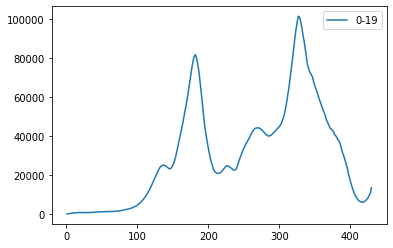

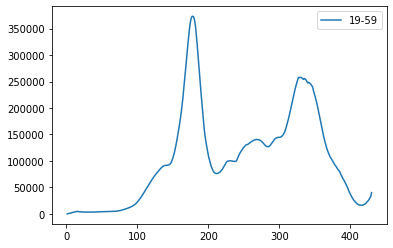

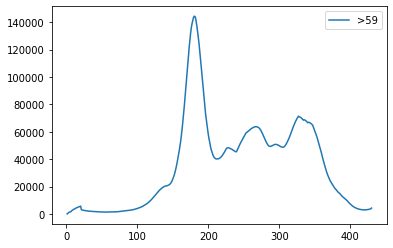

In [46]:
Inf_Rec_age = np.copy(D_cases_smooth)
for i in range(3):
  for k in range(1,n):
      Inf_Rec_age[i,k] +=Inf_Rec_age[i,k-1]     # I + R data

TVC = [15,16,20]

Inf_age = np.copy(D_cases_smooth)
for i in range(3):
  for k in range(TVC[i]):
    Inf_age[i,k]=np.sum(D_cases_smooth[i,0:k])
  for k in range(TVC[i],n):
    Inf_age[i,k]=np.sum(D_cases_smooth[i,k-12:k+1])

plt.figure(1)
plt.plot(np.linspace(1,n,n), N_people[0]*Inf_age[0,:], label = "0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(np.linspace(1,n,n), N_people[1]*Inf_age[1,:], label = "19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(np.linspace(1,n,n), N_people[2]*Inf_age[2,:], label = ">59")
plt.legend()
plt.show()



Now we want to calibrate the following model : 

\begin{equation} 
\left\{ \begin{array}{ll}
\frac{\partial S_1}{\partial t} = - \beta_1 I(t) S_1(t) \\
\frac{\partial I_1}{\partial t} = \beta_1 I(t) S_1(t) - \gamma_1 I_1(t)  \\
\frac{\partial S_2}{\partial t} = - \beta_2 I(t)S_2(t) \\
\frac{\partial I_2}{\partial t} = \beta_2 I(t)S_2(t)  - \gamma_2 I_2(t)  \\
\frac{\partial S_3}{\partial t} = - \beta_3 I(t)S_3(t) \\
\frac{\partial I_3}{\partial t} = \beta_3 I(t)S_3(t) - \gamma_3 I_3(t)
\end{array} \right.
\end{equation}

Indeed, according our model, the incidence rate depends on the mean number of contacts, so the serveral $\beta$ parameters take into account this phenomenon.
\
The parameters $\gamma_i$ will be fixes to values found in the article of Zanella (data_driven....)



In [47]:
t0 = 150 #begin of october
tf = 170  #end of october

gamma1 = 1/TVC[0]
gamma2 = 1/TVC[1]
gamma3 = 1/TVC[2]

def solve(x):
    beta1 = x[0]
    beta2 = x[1]
    beta3 = x[2]
    y0 = np.array([1-Inf_Rec_age[0,t0],Inf_age[0,t0],1-Inf_Rec_age[1,t0],Inf_age[1,t0],1-Inf_Rec_age[2,t0],Inf_age[2,t0]])
    t = np.linspace(0,tf-t0,tf-t0+1)
    f = lambda y,t : np.array([- beta1 * y[0]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta1 * y[0]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma1*y[1],- beta2 * y[2]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta2 * y[2]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma2*y[3],- beta3 * y[4]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta3 * y[4]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma1*y[5]])
    y = odeint(f,y0,t)
    s_1,i_1,s_2,i_2,s_3,i_3 = y[:,0],y[:,1],y[:,2],y[:,3],y[:,4],y[:,5]
    n1=0
    n2=0
    v1=0
    v2=0
    for i in range(tf-t0):
        n1+=(Inf_Rec_age[0,t0 +i]-(1-s_1[i]))**2
        v1+=Inf_Rec_age[0,t0 +i]**2
        n2+=(Inf_age[0,t0+i]-i_1[i])**2
        v2+=Inf_age[0,t0+i]**2
        n1+=(Inf_Rec_age[1,t0 +i]-(1-s_2[i]))**2
        v1+=Inf_Rec_age[1,t0 +i]**2
        n2+=(Inf_age[1,t0+i]-i_2[i])**2
        v2+=Inf_age[1,t0+i]**2
        n1+=(Inf_Rec_age[2,t0 +i]-(1-s_3[i]))**2
        v1+=Inf_Rec_age[2,t0 +i]**2
        n2+=(Inf_age[2,t0+i]-i_3[i])**2
        v2+=Inf_age[2,t0+i]**2
    return 1000*(0.9*np.sqrt(n2/v2) + 0.1*np.sqrt(n1/v1))

res = minimize(solve,[1,1,1],method = 'trust-constr',bounds = [(0,None),(0,None),(0,None)])

print(res)

x_fit_age = res.x

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 398
      cg_stop_cond: 2
            constr: [array([0.06642511, 0.15728474, 0.0995253 ])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 1.1647140979766846
               fun: 28.827510195782242
              grad: array([0.06564689, 0.60751724, 0.13888264])
               jac: [<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([0.00028838, 0.01466624, 0.00136218])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 604
              nhev: 0
               nit: 177
             niter: 177
              njev: 0
        optimality: 0.01466623760860275
            status: 2
           success: True
         tr_radius: 1.3883737315678951

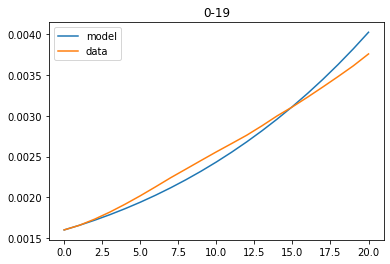

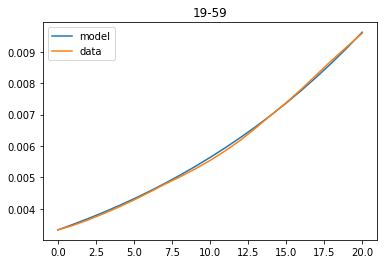

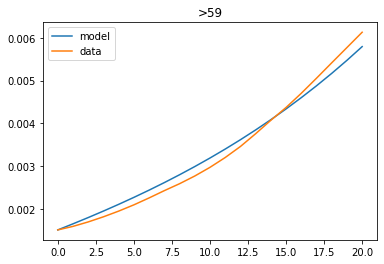

In [48]:
beta1 = x_fit_age[0]
beta2 = x_fit_age[1]
beta3 = x_fit_age[2]
gamma1 = 1/TVC[0]
gamma2 = 1/TVC[1]
gamma3 = 1/TVC[2]

y0 = np.array([1-Inf_Rec_age[0,t0],Inf_age[0,t0],1-Inf_Rec_age[1,t0],Inf_age[1,t0],1-Inf_Rec_age[2,t0],Inf_age[2,t0]])
t = np.linspace(0,tf-t0,tf-t0+1)
f = lambda y,t : np.array([- beta1 * y[0]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta1 * y[0]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma1*y[1],- beta2 * y[2]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta2 * y[2]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma2*y[3],- beta3 * y[4]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N ,beta3 * y[4]*(N_people[0]*y[1] + N_people[1]*y[3] + N_people[2]*y[5])/N - gamma1*y[5]])
y = odeint(f,y0,t)
s_1,i_1,s_2,i_2,s_3,i_3 = y[:,0],y[:,1],y[:,2],y[:,3],y[:,4],y[:,5]

plt.figure(1)
plt.plot(t,i_1,label = "model")
plt.plot(t,Inf_age[0,t0:tf+1],label="data")
plt.title("0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i_2,label = "model")
plt.plot(t,Inf_age[1,t0:tf+1],label="data")
plt.title("19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t,i_3,label = "model")
plt.plot(t,Inf_age[2,t0:tf+1],label="data")
plt.title(">59")
plt.legend()
plt.show()


## Vaccination data

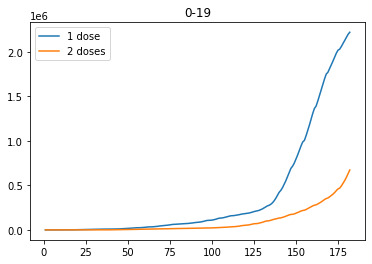

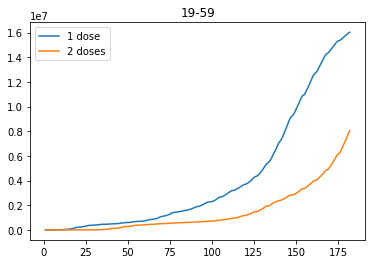

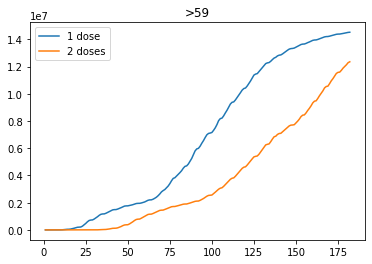

In [49]:
data = pd.read_csv ('vaccin_clage.csv', delimiter=";")

n = len(data.loc[(data["clage_vacsi"] == 24),:])

V_age1 = np.empty((3,n))  #3 classes of age : 0-19 ; 19 - 59 ; > 59
V_age2 = np.empty((3,n))


dates = data.loc[(data["clage_vacsi"] == 24) ,"jour"]


for k in range(n):
  V_age1[0,k] = data.loc[(data["clage_vacsi"] == 24) & (data["jour"] == dates.iloc[k]),"n_cum_dose1"].sum()
  V_age2[0,k] = data.loc[(data["clage_vacsi"] == 24) & (data["jour"] == dates.iloc[k]),"n_cum_complet"].sum()


for k in range(n):
  V_age1[1,k] = data.loc[( (data["clage_vacsi"] == 29) | (data["clage_vacsi"] == 39) | (data["clage_vacsi"] == 49) | (data["clage_vacsi"] == 59))  & (data["jour"] == dates.iloc[k]),"n_cum_dose1"].sum()
  V_age2[1,k] = data.loc[( (data["clage_vacsi"] == 29) | (data["clage_vacsi"] == 39) | (data["clage_vacsi"] == 49) | (data["clage_vacsi"] == 59))  & (data["jour"] == dates.iloc[k]),"n_cum_complet"].sum()

for k in range(n):
  V_age1[2,k] = data.loc[((data["clage_vacsi"] == 64) | (data["clage_vacsi"] == 69) | (data["clage_vacsi"] == 74) | (data["clage_vacsi"] == 79) | (data["clage_vacsi"] == 80))  & (data["jour"] == dates.iloc[k]),"n_cum_dose1"].sum()
  V_age2[2,k] = data.loc[((data["clage_vacsi"] == 64) | (data["clage_vacsi"] == 69) | (data["clage_vacsi"] == 74) | (data["clage_vacsi"] == 79) | (data["clage_vacsi"] == 80))  & (data["jour"] == dates.iloc[k]),"n_cum_complet"].sum()


plt.figure(1)
plt.plot(np.linspace(1,n,n),V_age1[0,:],label = "1 dose")
plt.plot(np.linspace(1,n,n),V_age2[0,:],label = "2 doses")
plt.title("0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(np.linspace(1,n,n),V_age1[1,:],label = "1 dose")
plt.plot(np.linspace(1,n,n),V_age2[1,:],label = "2 doses")
plt.title("19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(np.linspace(1,n,n),V_age1[2,:],label = "1 dose")
plt.plot(np.linspace(1,n,n),V_age2[2,:],label = "2 doses")
plt.title(">59")
plt.legend()
plt.show()

V_age1[0,:] /= N_people[0]
V_age1[1,:] /= N_people[1]
V_age1[2,:] /= N_people[2]

V_age2[0,:] /= N_people[0]
V_age2[1,:] /= N_people[1]
V_age2[2,:] /= N_people[2]

##Calibration of $V$

## 2 DOSES NECESSARY

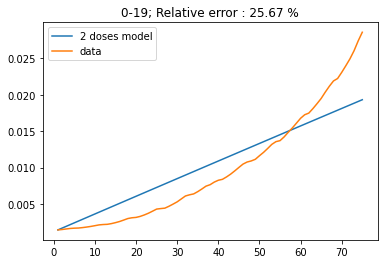

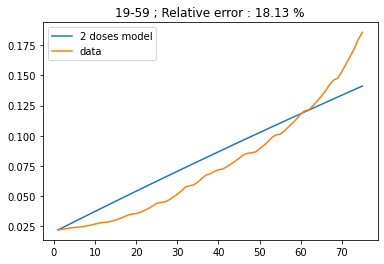

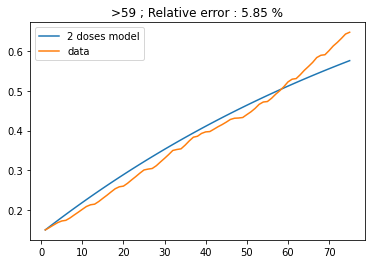

0.00024414062499911204 0.0017578124999991134 0.00942382812499912


In [50]:
start = 100
end = 175



s_0_1 = 1 - V_age2[0,start]
v_0_1 = V_age2[0,start]
y_0_1 = [s_0_1,v_0_1]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):    #0-19
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_1,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age2[0,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V2_1 = res.x[0]

f_v = lambda y, t : np.array([-V2_1*y[0],V2_1*y[0]])
Y = odeint(f_v,y_0_1,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "2 doses model")
error = np.sum(np.abs(v-V_age2[0,start:end]))/np.sum(V_age2[0,start:end])*10000//1/100
plt.plot(t,V_age2[0,start:end],label = "data")
plt.title("0-19; Relative error : "+str(error)+" %")
plt.legend()
plt.show()

start = 100
end = 175

s_0_2 = 1 - V_age2[1,start]
v_0_2 = V_age2[1,start]
y_0_2 = [s_0_2,v_0_2]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):   #19-59
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_2,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age2[1,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V2_2 = res.x[0]

f_v = lambda y, t : np.array([-V2_2*y[0],V2_2*y[0]])
Y = odeint(f_v,y_0_2,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "2 doses model")
error = np.sum(np.abs(v-V_age2[1,start:end]))/np.sum(V_age2[1,start:end])*10000//1/100
plt.plot(t,V_age2[1,start:end],label = "data")
plt.title("19-59 ; Relative error : "+str(error)+" %")
plt.legend()
plt.show()

start = 100
end = 175

s_0_3 = 1 - V_age2[2,start]
v_0_3 = V_age2[2,start]
y_0_3 = [s_0_3,v_0_3]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):   #>59
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_3,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age2[2,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V2_3 = res.x[0]

f_v = lambda y, t : np.array([-V2_3*y[0],V2_3*y[0]])
Y = odeint(f_v,y_0_3,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "2 doses model")
error = np.sum(np.abs(v-V_age2[2,start:end]))/np.sum(V_age2[2,start:end])*10000//1/100
plt.plot(t,V_age2[2,start:end],label = "data")
plt.title(">59 ; Relative error : "+str(error)+" %")
plt.legend()
plt.show()

print(V2_1,V2_2,V2_3)



## 1 DOSE IS SUFFICIENT

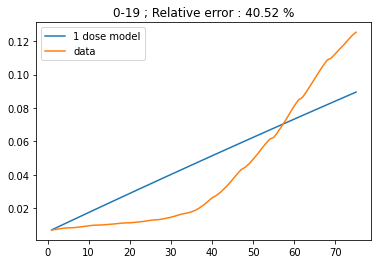

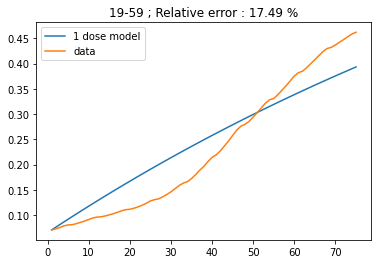

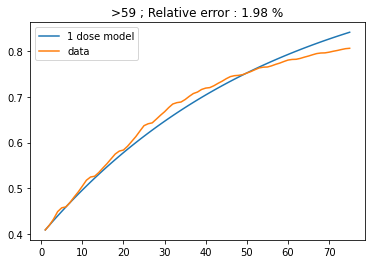

0.0011718749999991129 0.005761718749999117 0.017675781249999127


In [51]:
start = 100
end = 175



s_0_1 = 1 - V_age1[0,start]
v_0_1 = V_age1[0,start]
y_0_1 = [s_0_1,v_0_1]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):    #0-19
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_1,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age1[0,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V1_1 = res.x[0]

f_v = lambda y, t : np.array([-V1_1*y[0],V1_1*y[0]])
Y = odeint(f_v,y_0_1,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "1 dose model")
error = np.sum(np.abs(v-V_age1[0,start:end]))/np.sum(V_age1[0,start:end])*10000//1/100
plt.plot(t,V_age1[0,start:end],label = "data")
plt.title("0-19 ; Relative error : "+str(error)+ " %")
plt.legend()
plt.show()

start = 100
end = 175

s_0_2 = 1 - V_age1[1,start]
v_0_2 = V_age1[1,start]
y_0_2 = [s_0_2,v_0_2]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):   #19-59
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_2,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age1[1,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V1_2 = res.x[0]

f_v = lambda y, t : np.array([-V1_2*y[0],V1_2*y[0]])
Y = odeint(f_v,y_0_2,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "1 dose model")
error = np.sum(np.abs(v-V_age1[1,start:end]))/np.sum(V_age1[1,start:end])*10000//1/100
plt.plot(t,V_age1[1,start:end],label = "data")
plt.title("19-59 ; Relative error : "+str(error)+ " %")
plt.legend()
plt.show()

start = 100
end = 175

s_0_3 = 1 - V_age1[2,start]
v_0_3 = V_age1[2,start]
y_0_3 = [s_0_3,v_0_3]

t = np.linspace(1,end-start,end-start)

def solve_vaccin(x):   #>59
  V = x[0]
  f_v = lambda y, t : np.array([-V*y[0],V*y[0]])
  Y = odeint(f_v,y_0_3,t)
  s_v, v = Y[:,0], Y[:,1]
  norm = 0
  for k in range(end-start):
    norm += (v[k] - V_age1[2,start+k])**2
  return norm

res = minimize(solve_vaccin,[1],method = 'Nelder-Mead')


V1_3 = res.x[0]

f_v = lambda y, t : np.array([-V1_3*y[0],V1_3*y[0]])
Y = odeint(f_v,y_0_3,t)
s_v, v = Y[:,0], Y[:,1]

plt.figure(1)
plt.plot(t,v,label = "1 dose model")
error = np.sum(np.abs(v-V_age1[2,start:end]))/np.sum(V_age1[2,start:end])*10000//1/100
plt.plot(t,V_age1[2,start:end],label = "data")
plt.title(">59 ; Relative error : "+str(error)+ " %")
plt.legend()
plt.show()

print(V1_1,V1_2,V1_3)



## Extrapolation of H

## 2 doses

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

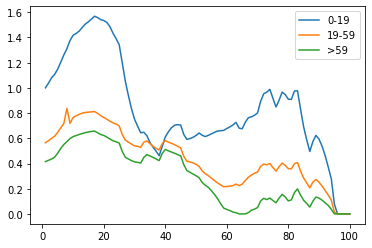

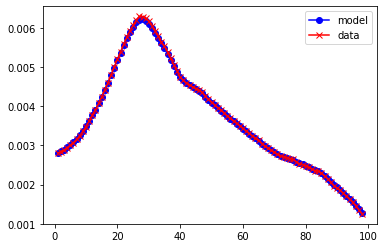

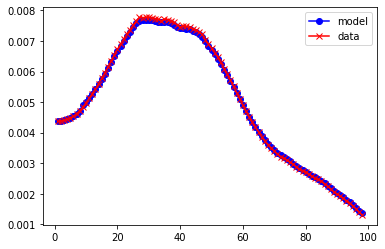

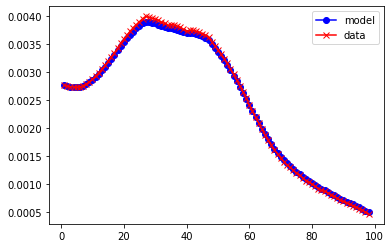

In [71]:
zeta_i = 1/180
zeta_v = 1/180
V1 = V2_1
V2 = V2_2
V3 = V2_3

x_H_1 = np.array([])
x_H_2 = np.array([])
x_H_3 = np.array([])


t0 = 300
tf = 400
db = 1
da = 1

V01 = V_age2[0,-len(Inf)+t0]
V02 = V_age2[1,-len(Inf)+t0]
V03 = V_age2[2,-len(Inf)+t0]

t = np.linspace(0,db+da,db+da+1)
beta1 = x_fit_age[0]
gamma1 = 1/TVC[0]
beta2 = x_fit_age[1]
gamma2 = 1/TVC[1]
beta3 = x_fit_age[2]
gamma3 = 1/TVC[2]

V01 = V_age2[0,-len(Inf)+t0]
V02 = V_age2[1,-len(Inf)+t0]
V03 = V_age2[2,-len(Inf)+t0]

y01 = np.array([1-Inf_Rec_age[0,t0]-V01,Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V01])
y02 = np.array([1-Inf_Rec_age[1,t0]-V02,Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V02])
y03 = np.array([1-Inf_Rec_age[2,t0]-V03,Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V03])

for d in range(t0,tf):
  def solve_H(H):
      f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[0] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[0] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
      g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
      h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[2] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[2] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
      def F(Y,t):
        y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
        return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
      Y0 = np.concatenate((y01,y02,y03))
      Y = odeint(F,Y0,t)
      i_1,i_2,i_3 = Y[:,1],Y[:,5],Y[:,9]
      n1=0
      n2=0
      n3=0
      v1=0
      v2=0
      v3=0
      for i in range(db+da+1):
        n1+=(Inf_age[0,d+i]-i_1[i])**2
        n2+=(Inf_age[1,d+i]-i_2[i])**2
        n3+=(Inf_age[2,d+i]-i_3[i])**2
        v1+=(Inf_age[0,d+i])**2
        v2+=(Inf_age[1,d+i])**2
        v3+=(Inf_age[2,d+i])**2
      return np.sqrt(n1/v1)+np.sqrt(n2/v2)+np.sqrt(n3/v3)
  res = minimize(solve_H,[0.5,0.5,0.5],method = 'trust-constr',bounds = ([(0,None),(0,None),(0,None)]))
  x_H_1 =np.concatenate((x_H_1,np.array([res.x[0]])))
  x_H_2 =np.concatenate((x_H_2,np.array([res.x[1]])))
  x_H_3 =np.concatenate((x_H_3,np.array([res.x[2]])))
  f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_1[-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_1[-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
  g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_2[-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_2[-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
  h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_3[-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_3[-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
  y01 = y01 + f(y01,y02,y03,t)
  y02 = y02 + g(y01,y02,y03,t)
  y03 = y03 + h(y01,y02,y03,t)

H2_age1 = x_H_1
H2_age2 = x_H_2
H2_age3 = x_H_3

plt.figure()
plt.plot(np.linspace(1,tf-t0,tf-t0),H2_age1,label = "0-19")
plt.plot(np.linspace(1,tf-t0,tf-t0),H2_age2,label = "19-59")
plt.plot(np.linspace(1,tf-t0,tf-t0),H2_age3, label = ">59")
plt.legend()
plt.show()

t = np.linspace(1,tf-t0-2,tf-t0-2)

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_12,i_22,i_32 = Y[:,1],Y[:,5],Y[:,9]
v_12,v_22,v_32 = Y[:,3],Y[:,7],Y[:,11]

plt.figure(1)
plt.plot(t,i_12,"b-o",label = "model")
plt.plot(t,Inf_age[0,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i_22,"b-o",label = "model")
plt.plot(t,Inf_age[1,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t,i_32,"b-o",label = "model")
plt.plot(t,Inf_age[2,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()



## 1 Dose

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

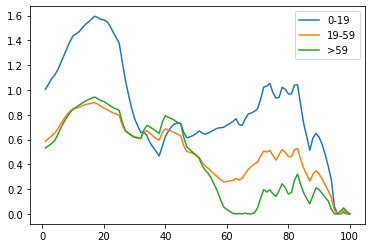

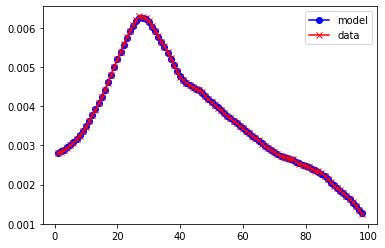

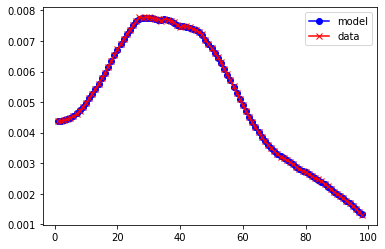

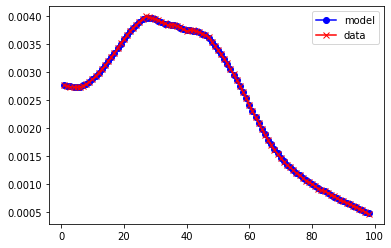

In [72]:
zeta_i = 1/180
zeta_v = 1/180
V1 = V1_1
V2 = V1_2
V3 = V1_3

x_H_1 = np.array([])
x_H_2 = np.array([])
x_H_3 = np.array([])


t0 = 300
tf = 400
db = 0
da = 2

t = np.linspace(0,db+da,db+da+1)
beta1 = x_fit_age[0]
gamma1 = 1/TVC[0]
beta2 = x_fit_age[1]
gamma2 = 1/TVC[1]
beta3 = x_fit_age[2]
gamma3 = 1/TVC[2]

V01 = V_age1[0,-len(Inf)+t0]
V02 = V_age1[1,-len(Inf)+t0]
V03 = V_age1[2,-len(Inf)+t0]

y01 = np.array([1-Inf_Rec_age[0,t0]-V01,Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V01])
y02 = np.array([1-Inf_Rec_age[1,t0]-V02,Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V02])
y03 = np.array([1-Inf_Rec_age[2,t0]-V03,Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V03])

for d in range(t0,tf):
  def solve_H(H):
      f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[0] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[0] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
      g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
      h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[2] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H[2] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
      def F(Y,t):
        y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
        return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
      Y0 = np.concatenate((y01,y02,y03))
      Y = odeint(F,Y0,t)
      i_1,i_2,i_3 = Y[:,1],Y[:,5],Y[:,9]
      n1=0
      n2=0
      n3=0
      v1=0
      v2=0
      v3=0
      for i in range(1,db+da+1):
        n1+=(Inf_age[0,d+i]-i_1[i])**2
        n2+=(Inf_age[1,d+i]-i_2[i])**2
        n3+=(Inf_age[2,d+i]-i_3[i])**2
        v1+=(Inf_age[0,d+i])**2
        v2+=(Inf_age[1,d+i])**2
        v3+=(Inf_age[2,d+i])**2
      return np.sqrt(n1/v1)+np.sqrt(n2/v2)+np.sqrt(n3/v3)
  res = minimize(solve_H,[0.5,0.5,0.5],method = 'trust-constr',bounds = ([(0,None),(0,None),(0,None)]))
  x_H_1 =np.concatenate((x_H_1,np.array([res.x[0]])))
  x_H_2 =np.concatenate((x_H_2,np.array([res.x[1]])))
  x_H_3 =np.concatenate((x_H_3,np.array([res.x[2]])))
  f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_1[-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_1[-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
  g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_2[-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_2[-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
  h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_3[-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*x_H_3[-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
  def F(Y,t):
        y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
        return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
  Y0 = np.concatenate((y01,y02,y03))
  Y = odeint(F,Y0,t)
  y01 = Y[1,:4]
  y02 = Y[1,4:8]
  y03 = Y[1,8:12]


H1_age1 = x_H_1
H1_age2 = x_H_2
H1_age3 = x_H_3

plt.figure()
plt.plot(np.linspace(1,tf-t0,tf-t0),H1_age1,label = "0-19")
plt.plot(np.linspace(1,tf-t0,tf-t0),H1_age2,label = "19-59")
plt.plot(np.linspace(1,tf-t0,tf-t0),H1_age3, label = ">59")
plt.legend()
plt.show()

t = np.linspace(1,tf-t0-2,tf-t0-2)

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age1[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age1[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age1[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age1[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age1[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age1[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_11,i_21,i_31 = Y[:,1],Y[:,5],Y[:,9]

plt.figure(1)
plt.plot(t,i_11,"b-o",label = "model")
plt.plot(t,Inf_age[0,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i_21,"b-o",label = "model")
plt.plot(t,Inf_age[1,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t,i_31,"b-o",label = "model")
plt.plot(t,Inf_age[2,t0:tf-2],"r-x",label = "data")
plt.legend()
plt.show()

Now, we can compare several strategies of vaccination.
Indeed, in France we vaccinated old people in priority, so we can focus on the case which we would vaccinate uniformly for example, or young people in priority.

In [73]:
V2_uniform = (V2_1*N_people[0] + V2_2*N_people[1] + V2_3* N_people[2])/N
print("The global intensity of vaccination (2 doses) is :"+str(V2_uniform))


V1_uniform = (V1_1*N_people[0] + V1_2*N_people[1] + V1_3* N_people[2])/N
print("The global intensity of vaccination (1 dose) is :"+str(V1_uniform))

The global intensity of vaccination (2 doses) is :0.0034403348882870895
The global intensity of vaccination (1 dose) is :0.007844164422619771


##Uniform Vaccination (2 doses)

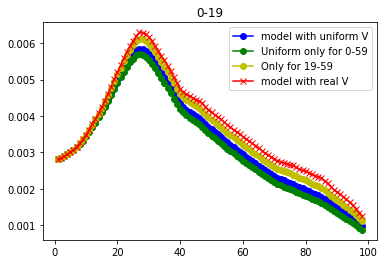

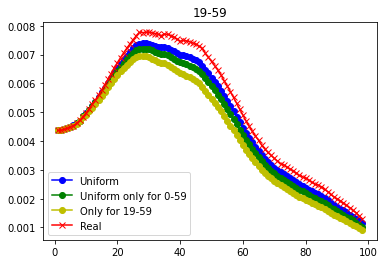

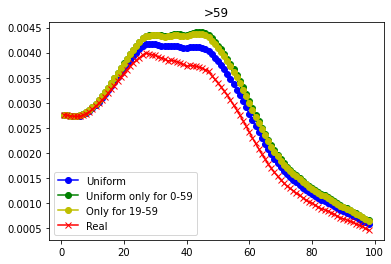

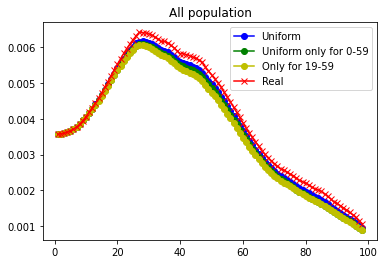

In [74]:
t = np.linspace(1,tf-t0-2,tf-t0-2)

V1 = V2_uniform
V2 = V2_uniform
V3 = V2_uniform


f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1,i_2,i_3 = Y[:,1],Y[:,5],Y[:,9]

V1 = V2_uniform*N/(N_people[0]+N_people[1])
V2 = V2_uniform*N/(N_people[0]+N_people[1])
V3 = 0

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1_bis,i_2_bis,i_3_bis = Y[:,1],Y[:,5],Y[:,9]

V1 = 0
V2 = V2_uniform*N/(N_people[1])
V3 = 0

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1_t,i_2_t,i_3_t = Y[:,1],Y[:,5],Y[:,9]

plt.figure(1)
plt.plot(t,i_1,"b-o",label = "model with uniform V")
plt.plot(t,i_1_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_1_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[0,t0:tf-2],"r-x",label = "model with real V")
plt.title("0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i_2,"b-o",label = "Uniform")
plt.plot(t,i_2_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_2_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[1,t0:tf-2],"r-x",label = "Real")
plt.title("19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t,i_3,"b-o",label = "Uniform")
plt.plot(t,i_3_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_3_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[2,t0:tf-2],"r-x",label = "Real")
plt.title(">59")
plt.legend()
plt.show()

plt.figure(4)
plt.plot(t,(N_people[0]*i_1 + N_people[1]*i_2 + N_people[2]*i_3)/N,"b-o",label = "Uniform")
plt.plot(t,(N_people[0]*i_1_bis + N_people[1]*i_2_bis + N_people[2]*i_3_bis)/N,"g-o",label = "Uniform only for 0-59")
plt.plot(t,(N_people[0]*i_1_t + N_people[1]*i_2_t + N_people[2]*i_3_t)/N,"y-o",label = "Only for 19-59")
plt.plot(t,(N_people[0]*Inf_age[0,t0:tf-2]+ N_people[1]*Inf_age[1,t0:tf-2] + N_people[2]*Inf_age[2,t0:tf-2])/N,"r-x",label = "Real")
plt.title("All population")
plt.legend()
plt.show()

## 1 dose

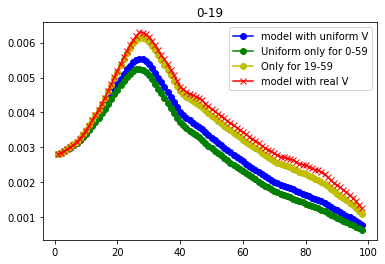

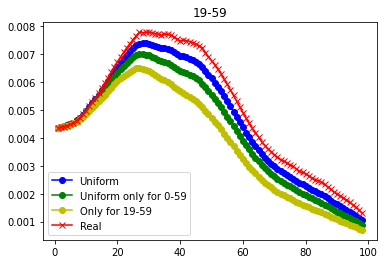

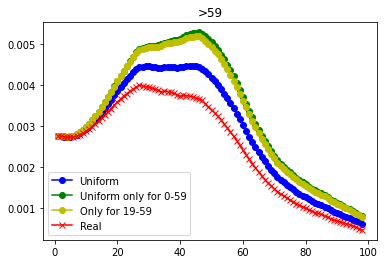

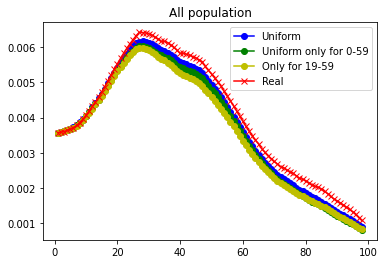

In [75]:
t = np.linspace(1,tf-t0-2,tf-t0-2)

V1 = V1_uniform
V2 = V1_uniform
V3 = V1_uniform

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-2] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age1[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age1[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age1[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age1[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age1[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age1[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1,i_2,i_3 = Y[:,1],Y[:,5],Y[:,9]

V1 = V1_uniform*N/(N_people[0]+N_people[1])
V2 = V1_uniform*N/(N_people[0]+N_people[1])
V3 = 0

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age1[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age1[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age1[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age1[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age1[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age1[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1_bis,i_2_bis,i_3_bis = Y[:,1],Y[:,5],Y[:,9]

V1 = 0
V2 = V1_uniform*N/(N_people[1])
V3 = 0

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age1[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age2[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H1_age3[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age1[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age1[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age1[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age1[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age1[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age1[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_1_t,i_2_t,i_3_t = Y[:,1],Y[:,5],Y[:,9]

plt.figure(1)
plt.plot(t,i_1,"b-o",label = "model with uniform V")
plt.plot(t,i_1_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_1_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[0,t0:tf-2],"r-x",label = "model with real V")
plt.title("0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t,i_2,"b-o",label = "Uniform")
plt.plot(t,i_2_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_2_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[1,t0:tf-2],"r-x",label = "Real")
plt.title("19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t,i_3,"b-o",label = "Uniform")
plt.plot(t,i_3_bis,"g-o",label = "Uniform only for 0-59")
plt.plot(t,i_3_t,"y-o",label = "Only for 19-59")
plt.plot(t,Inf_age[2,t0:tf-2],"r-x",label = "Real")
plt.title(">59")
plt.legend()
plt.show()

plt.figure(4)
plt.plot(t,(N_people[0]*i_1 + N_people[1]*i_2 + N_people[2]*i_3)/N,"b-o",label = "Uniform")
plt.plot(t,(N_people[0]*i_1_bis + N_people[1]*i_2_bis + N_people[2]*i_3_bis)/N,"g-o",label = "Uniform only for 0-59")
plt.plot(t,(N_people[0]*i_1_t + N_people[1]*i_2_t + N_people[2]*i_3_t)/N,"y-o",label = "Only for 19-59")
plt.plot(t,(N_people[0]*Inf_age[0,t0:tf-2] + N_people[1]*Inf_age[1,t0:tf-2] + N_people[2]*Inf_age[2,t0:tf-2])/N,"r-x",label = "Real")
plt.title("All population")
plt.legend()
plt.show()

# Predictions

First, we have to interpolate the function $H$ for the next 20 days.

---


1) linear interpolation
2) constant interpolation

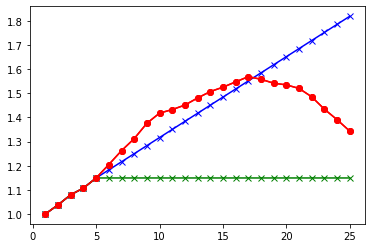

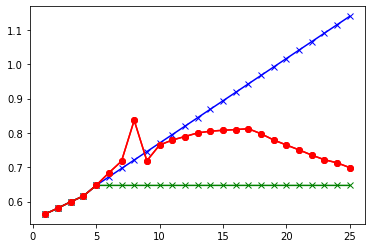

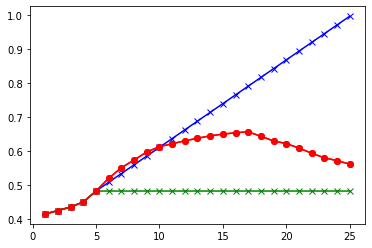

In [91]:
t0 = 300
tf = 380
b = 0
s = 5
e = 25
#b = 80
#s = 108
#e = 138
t = np.linspace(b,s,s-b)
tbis = np.linspace(s,e,e-s+1)
T = np.linspace(1,e,e)

f = interpolate.interp1d(t, H2_age1[b:s], kind = "slinear",fill_value="extrapolate") # autorise l'extrapolation
H2_age1_ex = np.concatenate((H2_age1[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(1)
plt.plot(T,H2_age1_ex,"b-x")
plt.plot(T,H2_age1[:e],"r-o")

f = interpolate.interp1d(t, H2_age2[b:s], kind = "slinear",fill_value="extrapolate") # autorise l'extrapolation
H2_age2_ex = np.concatenate((H2_age2[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(2)
plt.plot(T,H2_age2_ex,"b-x")
plt.plot(T,H2_age2[:e],"r-o")

f = interpolate.interp1d(t, H2_age3[b:s], kind = "slinear",fill_value="extrapolate") # autorise l'extrapolation
H2_age3_ex = np.concatenate((H2_age3[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(3)
plt.plot(T,H2_age3_ex,"b-x")
plt.plot(T,H2_age3[:e],"r-o")



f = interpolate.interp1d(t, H2_age1[b:s], kind = "zero",fill_value="extrapolate") # autorise l'extrapolation
H2_age1_const = np.concatenate((H2_age1[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(1)
plt.plot(T,H2_age1_const,"g-x")
plt.plot(T,H2_age1[:e],"r-o")

f = interpolate.interp1d(t, H2_age2[b:s], kind = "zero",fill_value="extrapolate") # autorise l'extrapolation
H2_age2_const = np.concatenate((H2_age2[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(2)
plt.plot(T,H2_age2_const,"g-x")
plt.plot(T,H2_age2[:e],"r-o")

f = interpolate.interp1d(t, H2_age3[b:s], kind = "zero",fill_value="extrapolate") # autorise l'extrapolation
H2_age3_const = np.concatenate((H2_age3[:s-1],np.array(f.__call__(tbis)))) # on peut ajouter extrapolate=True lors de l'évaluation

plt.figure(3)
plt.plot(T,H2_age3_const,"g-x")
plt.plot(T,H2_age3[:e],"r-o")


Now we can make predictions on the number of infected people.

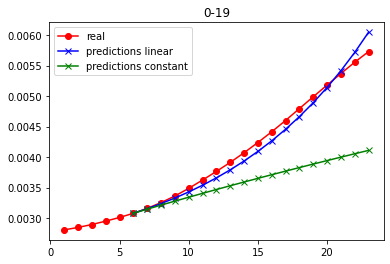

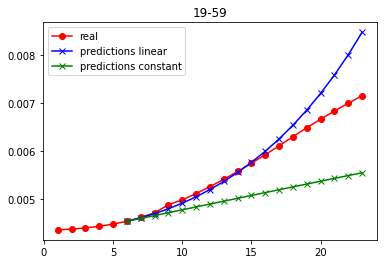

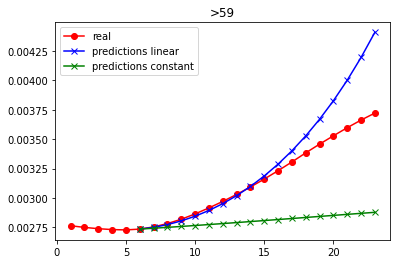

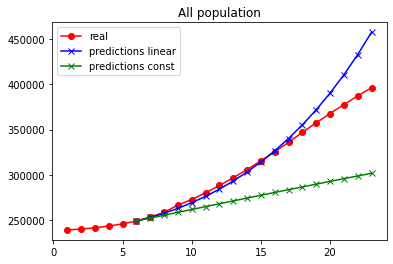

In [92]:
t = np.linspace(1,e-2,e-2)

V1 = V2_1
V2 = V2_2
V3 = V2_3

f = lambda y1,y2,y3 , t : np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_ex[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_ex[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
g = lambda y1,y2,y3 , t : np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_ex[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_ex[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
h = lambda y1,y2,y3 , t : np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_ex[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_ex[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_12_ex,i_22_ex,i_32_ex = Y[:,1],Y[:,5],Y[:,9]

def f(y1,y2,y3 , t):
  if t<110:
    return np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_const[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_const[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],V1*y1[0] - zeta_v*y1[3]])
  else:
    return np.array([-beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_const[int(t)-1] + zeta_v*y1[3] + zeta_i*y1[2] - 3*V1*y1[0],beta1*y1[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age1_const[int(t)-1] - gamma1 * y1[1],gamma1*y1[1] - zeta_i * y1[2],3*V1*y1[0] - zeta_v*y1[3]])

def g(y1,y2,y3 , t) : 
  if t<110:
    return np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_const[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_const[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],V2*y2[0] - zeta_v*y2[3]])
  else:
    return np.array([-beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_const[int(t)-1] + zeta_v*y2[3] + zeta_i*y2[2] - 3*V2*y2[0],beta2*y2[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age2_const[int(t)-1] - gamma2 * y2[1],gamma2*y2[1] - zeta_i * y2[2],3*V2*y2[0] - zeta_v*y2[3]])


def h(y1,y2,y3 , t):
  if t < 110 : 
    return np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_const[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_const[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],V3*y3[0] - zeta_v*y3[3]])
  else:
    return np.array([-beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_const[int(t)-1] + zeta_v*y3[3] + zeta_i*y3[2] - 3*V3*y3[0],beta3*y3[0]*(N_people[0]*y1[1]+N_people[1]*y2[1]+N_people[2]*y3[1])/N*H2_age3_const[int(t)-1] - gamma3 * y3[1],gamma3*y3[1] - zeta_i * y3[2],3*V3*y3[0] - zeta_v*y3[3]])

def F(Y,t):
  y1,y2,y3 = Y[:4],Y[4:8],Y[8:]
  return np.concatenate((f(y1,y2,y3,t),g(y1,y2,y3,t),h(y1,y2,y3,t)))
y01 = np.array([1-Inf_Rec_age[0,t0]-V_age2[0,-len(Inf)+t0],Inf_age[0,t0],Inf_Rec_age[0,t0] - Inf_age[0,t0],V_age2[0,-len(Inf)+t0]])
y02 = np.array([1-Inf_Rec_age[1,t0]-V_age2[1,-len(Inf)+t0],Inf_age[1,t0],Inf_Rec_age[1,t0] - Inf_age[1,t0],V_age2[1,-len(Inf)+t0]])
y03 = np.array([1-Inf_Rec_age[2,t0]-V_age2[2,-len(Inf)+t0],Inf_age[2,t0],Inf_Rec_age[2,t0] - Inf_age[2,t0],V_age2[2,-len(Inf)+t0]])
Y0 = np.concatenate((y01,y02,y03))
Y = odeint(F,Y0,t)
i_12_const,i_22_const,i_32_const = Y[:,1],Y[:,5],Y[:,9]

plt.figure(1)
plt.plot(t[:e-2],i_12[:e-2],"r-o",label = "real")
plt.plot(t[s:e],i_12_ex[s:e],"b-x",label = "predictions linear")
plt.plot(t[s:e],i_12_const[s:e],"g-x",label = "predictions constant")
plt.title("0-19")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t[:e-2],i_22[:e-2],"r-o",label = "real")
plt.plot(t[s:e],i_22_ex[s:e],"b-x",label = "predictions linear")
plt.plot(t[s:e],i_22_const[s:e],"g-x",label = "predictions constant")
plt.title("19-59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t[:e-2],i_32[:e-2],"r-o",label = "real")
plt.plot(t[s:e],i_32_ex[s:e],"b-x",label = "predictions linear")
plt.plot(t[s:e],i_32_const[s:e],"g-x",label = "predictions constant")
plt.title(">59")
plt.legend()
plt.show()

plt.figure(3)
plt.plot(t[:e-2],(N_people[0]*i_12[:e-2]+N_people[1]*i_22[:e-2]+N_people[2]*i_32[:e-2]),"r-o",label = "real")
plt.plot(t[s:e],(N_people[0]*i_12_ex[s:e]+N_people[1]*i_22_ex[s:e]+N_people[2]*i_32_ex[s:e]),"b-x",label = "predictions linear")
plt.plot(t[s:e],(N_people[0]*i_12_const[s:e]+N_people[1]*i_22_const[s:e]+N_people[2]*i_32_const[s:e]),"g-x",label = "predictions const")
plt.title("All population")
plt.legend()
plt.show()